# Medical Imaging & Big Data

# 1. Introduction, Libraries, Setups
[testo]

In [1]:
#For installing PyTorch and dependencies (uncomment)
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#For importing PyTorch and see if GPU is available
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using", device, "device")

Using cuda device


In [3]:
#For setting default device to GPU (uncomment)
#torch.set_default_device('cuda')

In [4]:
#For installing other dependencies (uncomment)
#%pip install setuptools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
#For installing other dependencies (uncomment)
# %pip install pydicom numpy matplotlib pandas gdcm opencv-python scikit-image scikit-learn tqdm
# %pip install tabulate
# %pip install albumentations
##!conda install -c conda-forge gdcm -y

  Obtaining dependency information for gdcm from https://files.pythonhosted.org/packages/ec/45/eb03dc3d3813a2840bddeb5eb91782de6d06c423aeed1ebaff462a083cf3/gdcm-1.1-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB 1.3 MB/s eta 0:00:04
   -- ------------------------------------- 0.2/4.0 MB 3.6 MB/s eta 0:00:02
   ---------- ----------------------------- 1.0/4.0 MB 11.0 MB/s eta 0:00:01
   ---------- ----------------------------- 1.0/4.0 MB 11.0 MB/s eta 0:00:01
   -------------------- ------------------- 2.1/4.0 MB 10.2 MB/s eta 0:00:01
   -------------------- ------------------- 2.1/4

ERROR: Could not install packages due to an OSError: [WinError 5] Accesso negato: 'c:\\Users\\alexc\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for tabulate from https://files.pythonhosted.org/packages/40/44/4a5f08c96eb108af5cb50b41f76142f0afa346dfa99d5296fe7202a11854/tabulate-0.9.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/46/17/fa819a9dd0da2bf53a30df2e0092c59bf80bf13b9e51d0d087c1baef05ec/albumentations-1.4.11-py3-none-any.whl.metadata
  Obtaining dependency information for PyYAML from https://files.pythonhosted.org/packages/2b/9f/fbade56564ad486809c27b322d0f7e6a89c01f6b4fe208402e90d4443a99/PyYAML-6.0.1-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for pydantic>=2.7.0 from https://files.pythonhosted.org/packages/1f/fa/b7f815b8c9ad021c07f88875b601222ef5e70619391ade4a49234d12d278/pydantic-2.8.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/125.2 kB ? eta -:--:--
     -------------------------------------- 125.2/125.2 kB 7.7 MB/s eta 0:00:00
  Obtaining dependency information for albucore>=0.0.11 from https://files.pythonhosted.org/packages/9f/c4/6e42a9610a712cc93b04176882a2f4ef9d71fcfe2a050a608eab39f022cd/albucore-0.0.12-py3-none-any.whl.metadata
  Obtain


[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 2. Dataset Preprocessing

### Image preprocessing notes
1. **Reading the DICOM file**:
The choice to use pydicom's dcmread function is due to its specialized capability in handling DICOM format. DICOM files contain both metadata and pixel data, and pydicom efficiently extracts this information.

2. **Converting to float32**:
The pixel array is converted to float32 to ensure precision in subsequent calculations. Float32 provides a good balance between numerical accuracy and memory efficiency.

3. **Normalization to [0, 1]**:
This step scales the pixel values to a consistent range. The choice of [0, 1] is common in image processing as it provides a standardized input range for machine learning models. This normalization helps in comparing images with different original intensity ranges and can improve model convergence during training.

4. **Applying CLAHE**:
Contrast Limited Adaptive Histogram Equalization (CLAHE) is chosen to enhance image contrast. Unlike global histogram equalization, CLAHE operates on small regions, making it particularly effective for medical images where local contrast is crucial. The clipLimit of 2.0 and tileGridSize of (8, 8) are chosen as balanced parameters that enhance contrast without over-amplifying noise.

5. **Resizing to 224x224**:
This size is chosen because it's a common input size for many Convolutional Neural Network (CNN) architectures, particularly those pre-trained on ImageNet. Standardizing the size ensures compatibility with these architectures and maintains a consistent input shape for the model.

6. **Converting to PyTorch tensor**:
The final conversion to a PyTorch tensor prepares the image for use with PyTorch's deep learning framework. This step also typically includes channel-first rearrangement and normalization to the range [0, 1], which is why the earlier [0, 255] conversion for CLAHE doesn't conflict with this step.

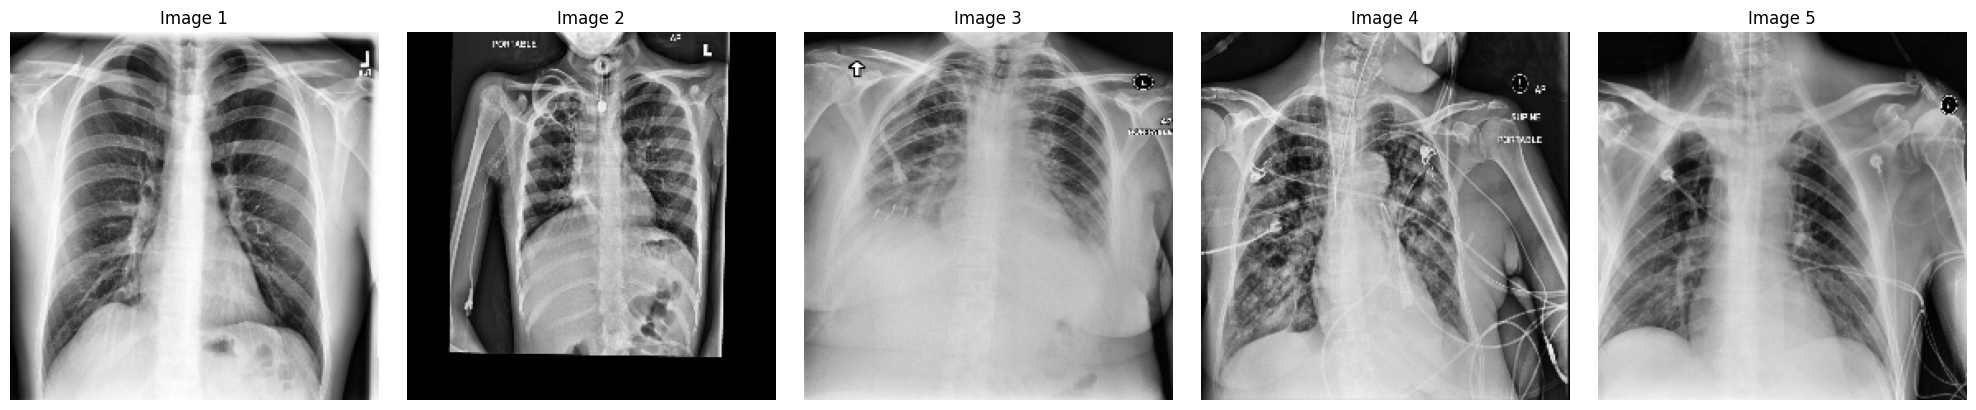

Total number of images: 10719
Preprocessed image shape: torch.Size([5, 1, 224, 224])


In [2]:
import os
import numpy as np
import pydicom
import cv2
from skimage import exposure
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Set the device to CUDA if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess_dicom(dicom_path):
    """
    Preprocess a single DICOM image.
    Steps:
    1. Read DICOM file
    2. Extract pixel array
    3. Normalize pixel values
    4. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    5. Resize image to a standard size
    6. Convert to PyTorch tensor
    """
    # Read DICOM file
    dicom = pydicom.dcmread(dicom_path)

    # Extract pixel array and convert to float
    image = dicom.pixel_array.astype(np.float32)

    # Normalize pixel values to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply((image * 255).astype(np.uint8))

    # Resize image to a standard size (e.g., 224x224 for many CNN architectures)
    image = cv2.resize(image, (224, 224))

    # Convert to PyTorch tensor
    image_tensor = transforms.ToTensor()(image)

    # Move tensor to the defined device
    return image_tensor.to(device)

class DicomDataset(Dataset):
    """
    Custom Dataset class for DICOM images.
    """
    def __init__(self, dicom_dir):
        self.dicom_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]

    def __len__(self):
        return len(self.dicom_files)

    def __getitem__(self, idx):
        return preprocess_dicom(self.dicom_files[idx])

# Set up the dataset and dataloader
dicom_dir = "dicom_files"
dataset = DicomDataset(dicom_dir)
dataloader = DataLoader(dataset, batch_size=5, shuffle=False)

# Fetch and display the first 5 preprocessed images
first_batch = next(iter(dataloader))

# Display the first 5 preprocessed images using matplotlib
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, img in enumerate(first_batch):
    img_cpu = img.cpu()  # Move tensor back to CPU for plotting
    axes[i].imshow(img_cpu.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")
plt.tight_layout()
plt.show()

print(f"Total number of images: {len(dataset)}")
print(f"Preprocessed image shape: {first_batch.shape}")


## Metadata Extraction and Exploration


In [3]:
import os
import pydicom
import pandas as pd

def extract_metadata(dicom_dir):
    metadata_list = []
    for filename in os.listdir(dicom_dir):
        if filename.endswith('.dcm'):
            dicom_path = os.path.join(dicom_dir, filename)
            dicom = pydicom.dcmread(dicom_path)
            metadata = {
                'filename': filename,
                'PatientID': dicom.get('PatientID', ''),
                'PatientAge': dicom.get('PatientAge', ''),
                'PatientSex': dicom.get('PatientSex', ''),
                'PatientWeight': dicom.get('PatientWeight', ''),
                'StudyDate': dicom.get('StudyDate', ''),
                'Modality': dicom.get('Modality', ''),
                'BodyPartExamined': dicom.get('BodyPartExamined', '')
            }
            metadata_list.append(metadata)
    
    return pd.DataFrame(metadata_list)

# Extract metadata
dicom_dir = "dicom_files"
metadata_df = extract_metadata(dicom_dir)

# Save to CSV
metadata_df.to_csv('dicom_metadata.csv', index=False)

# Display the first five rows
print(metadata_df.head())

                                            filename  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...   
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...   
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...   

                              PatientID PatientAge PatientSex PatientWeight  \
0  17d405a3-a0d2-4901-b33a-63906aa48d9f         38          M                 
1  8ab1ffda-8b65-4914-95d6-2e549e328666         10          F                 
2  bfef51d3-6541-4792-bac1-d21d41ee60fd         50          F                 
3  d19d956f-4ddd-4688-81ff-909c85e0e2d9         68          F                 
4  cf71a760-f693-4ccf-acd4-a41ff4845a5f         65          M                 

  StudyDate Modality BodyPartExamined  
0  19010101       CR            CHEST  
1  19010101       CR            CHEST  
2  19010101       CR            CHEST  
3  19010101       CR        

Processing DICOM files: 100%|██████████| 11582/11582 [00:09<00:00, 1235.73it/s]



Unique values in EncodedPixels:
[' -1'
 ' 175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 1000 23 999 23 1000 22 1001 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1002 21 1002 20 1003 20 1002 21 1001 23 1000 23 999 24 999 24 999 23 999 24 999 24 998 26 996 27 995 28 995 28 994 30 993 30 993 30 993 30 993 31 992 31 992 31 992 31 992 32 990 33 990 33 990 33 991 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 993 30 993 30 993 30 993 30 994 29 994 29 994 30 993 30 994 29 994 30 993 30 993 31 993 31 992 31 992 31 992 32 992 31 992 31 992 31 992 32 992 31 992 31 992 31 992 32 992 31 992 31 992 31 992 32 992 31 992 31 992 31 992 32 992 31 992 31 992 32 992 31 992 32 992 32 991 32 992 31 992 32 991 32 992 31 992 32 991 32 992 32 991 33 990 33 990 34 990 33 990 34 989 34 990 34 989 35 989 35 988 35 989 35 988 36 987 36 988 36 987 37 987 36 987 37 987 36 987 37 987 36 9

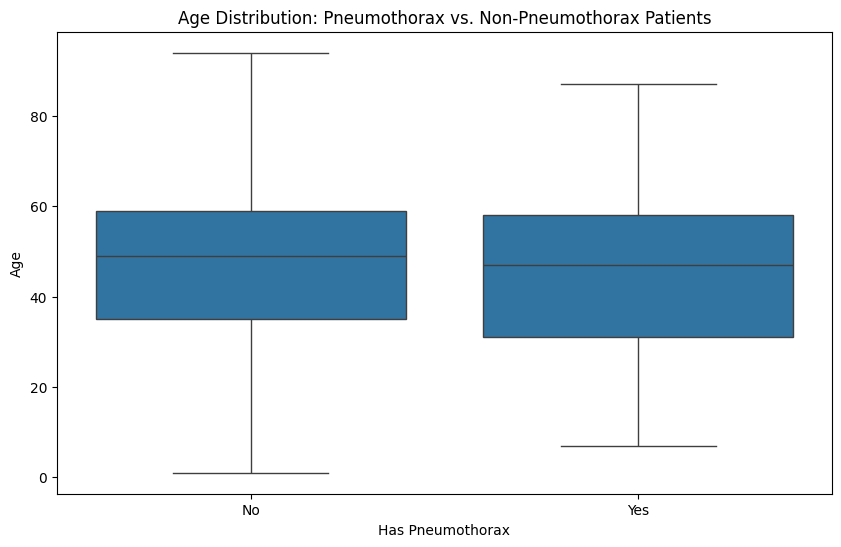


Pneumothorax Patients Age Statistics:
count    6026.000000
mean       44.912878
std        16.782530
min         7.000000
25%        31.000000
50%        47.000000
75%        58.000000
max        87.000000
Name: PatientAge, dtype: float64

Non-Pneumothorax Patients Age Statistics:
count    8294.000000
mean       47.261755
std        16.501328
min         1.000000
25%        35.000000
50%        49.000000
75%        59.000000
max        94.000000
Name: PatientAge, dtype: float64


In [4]:
import os
import pandas as pd
import pydicom
import numpy as np
from tqdm import tqdm

# Load the original CSV file
csv_path = 'train-rle.csv'
df = pd.read_csv(csv_path)

# Function to extract relevant metadata from DICOM files
def extract_dicom_metadata(dicom_path):
    try:
        dicom = pydicom.dcmread(dicom_path)
        age = dicom.PatientAge if 'PatientAge' in dicom else np.nan
        # Convert age to float, removing 'Y' if present
        age_float = float(str(age).replace('Y', '')) if pd.notna(age) else np.nan
        return {
            'PatientID': dicom.PatientID,
            'PatientSex': dicom.PatientSex,
            'PatientAge': age_float,
            'ViewPosition': dicom.ViewPosition,
            'Modality': dicom.Modality,
            'ImageSize': f"{dicom.Rows}x{dicom.Columns}"
        }
    except:
        return None

# Directory containing DICOM files
dicom_dir = 'dicom_files'

# Create a list to store metadata
metadata_list = []

# Iterate through DICOM files and extract metadata
for image_id in tqdm(df['ImageId'], desc="Processing DICOM files"):
    dicom_path = os.path.join(dicom_dir, f"{image_id}.dcm")
    if os.path.exists(dicom_path):
        metadata = extract_dicom_metadata(dicom_path)
        if metadata:
            metadata['ImageId'] = image_id
            metadata_list.append(metadata)

# Create a DataFrame from the metadata list
metadata_df = pd.DataFrame(metadata_list)

# Merge the original DataFrame with the metadata DataFrame
merged_df = pd.merge(df, metadata_df, on='ImageId', how='left')

# Create HasPneumothorax column
merged_df['HasPneumothorax'] = merged_df['EncodedPixels'].apply(lambda x: 0 if str(x).strip() == '-1' else 1)

print("\nUnique values in EncodedPixels:")
print(merged_df['EncodedPixels'].unique())

print("\nDistribution of HasPneumothorax:")
print(merged_df['HasPneumothorax'].value_counts(normalize=True))

print("\nCross-tabulation of EncodedPixels and HasPneumothorax:")
print(pd.crosstab(merged_df['EncodedPixels'], merged_df['HasPneumothorax']))

# Drop patients with age > 100 (adjust as needed)
merged_df = merged_df[merged_df['PatientAge'] <= 100]

# Display some information about the merged dataset
print("Shape of merged dataset:", merged_df.shape)
print("\nColumns in merged dataset:", merged_df.columns)
print("\nDistribution of HasPneumothorax:")
print(merged_df['HasPneumothorax'].value_counts(normalize=True))
print("\nSample of merged data:")
print(merged_df.sample(5))

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('pneumothorax_dataset_with_metadata_cleaned.csv', index=False)

# Create the age distribution plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='HasPneumothorax', y='PatientAge', data=merged_df)
plt.title('Age Distribution: Pneumothorax vs. Non-Pneumothorax Patients')
plt.xlabel('Has Pneumothorax')
plt.ylabel('Age')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Print summary statistics for each group
pneumothorax_ages = merged_df[merged_df['HasPneumothorax'] == 1]['PatientAge']
non_pneumothorax_ages = merged_df[merged_df['HasPneumothorax'] == 0]['PatientAge']

print("\nPneumothorax Patients Age Statistics:")
print(pneumothorax_ages.describe())
print("\nNon-Pneumothorax Patients Age Statistics:")
print(non_pneumothorax_ages.describe())

In [5]:
#%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


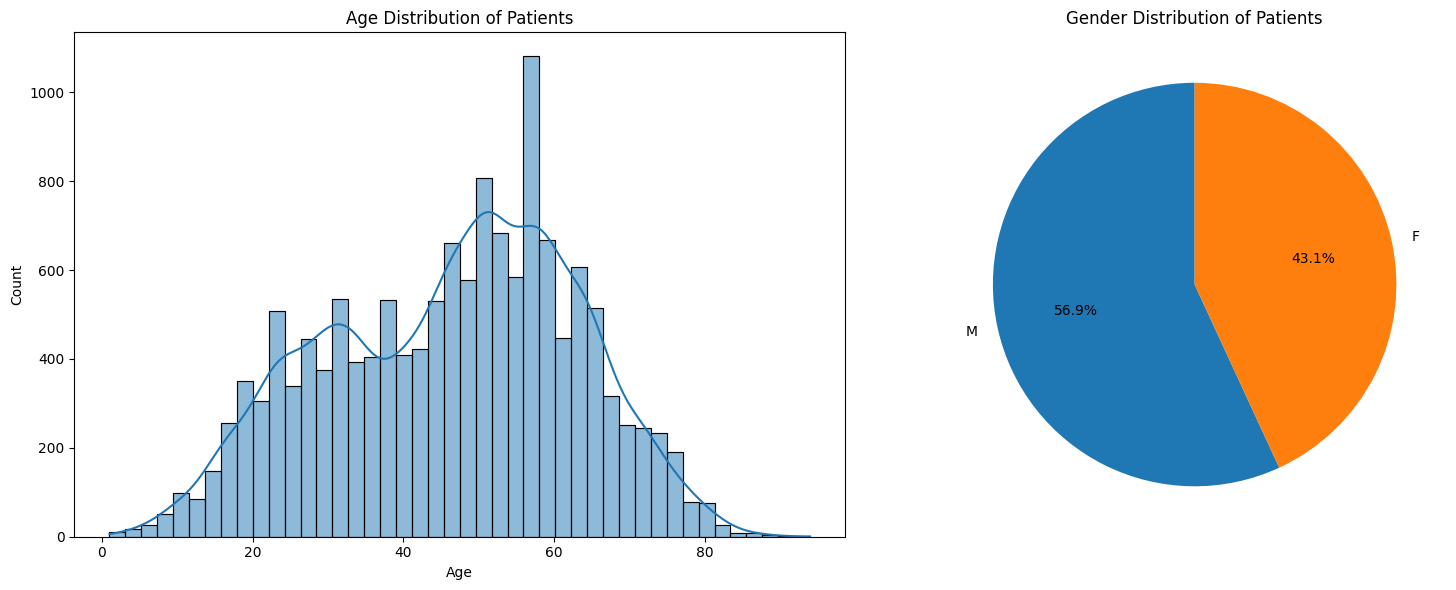

count    14320.000000
mean        46.273324
std         16.660066
min          1.000000
25%         33.000000
50%         48.000000
75%         59.000000
max         94.000000
Name: PatientAge, dtype: float64

Gender Distribution:
PatientSex
M    8146
F    6174
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to clean and convert age
def clean_age(age):
    if pd.isna(age):
        return np.nan
    if isinstance(age, str):
        return float(age.replace('Y', ''))
    return float(age)

# Ensure the 'PatientAge' column is numeric
merged_df['PatientAge'] = merged_df['PatientAge'].apply(clean_age)

# Set up the plot style
plt.style.use('default')  # Using default Matplotlib style
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Age distribution
sns.histplot(data=merged_df, x='PatientAge', kde=True, ax=ax1)
ax1.set_title('Age Distribution of Patients')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')

# Gender distribution
gender_counts = merged_df['PatientSex'].value_counts()
ax2.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Gender Distribution of Patients')

plt.tight_layout()
plt.show()

# Print summary statistics
print(merged_df['PatientAge'].describe())
print("\nGender Distribution:")
print(gender_counts)

# 3. Deep Learning using Convolutional Neural Networks

## Sex prediction 

The following code implements a comprehensive pipeline for training and evaluating multiple deep learning models on DICOM data for a binary classification task (sex).

1. **Setup and Data Handling**:
   - The code uses *PyTorch* for deep learning, along with supporting libraries like pandas for data manipulation and pydicom for reading DICOM files.
   - A custom DicomDataset class is implemented to load DICOM images and their corresponding labels.
   - The dataset is split into training and validation sets.
   - Images are preprocessed: normalized, resized to 224x224, and converted to PyTorch tensors.

2. **Model Architectures**:
   Four different models are implemented, each inspired by different approaches in medical imaging:

   a) SimpleCNN: A basic convolutional neural network with two convolutional layers followed by fully connected layers. This serves as a baseline model.

   b) CheXNet-inspired: Based on DenseNet121, which was used in the original CheXNet for chest X-ray classification. DenseNets are known for their ability to maintain low-level features throughout the network.

   c) X-RayGAN-inspired: A simplified version of a GAN-based approach. It uses an encoder-decoder architecture with a separate classifier. While not used as a GAN here, this architecture can capture useful features in the encoder part.

   d) CheXpert-inspired: Uses ResNet18 as a backbone, inspired by the CheXpert project. ResNets are known for their ability to train very deep networks effectively, which can be beneficial for complex medical imaging tasks.

   These choices represent a good mix of simple and complex architectures, all of which have shown success in medical imaging tasks. They range from a basic CNN to more sophisticated transfer learning approaches using pre-trained networks.

3. **Training Process**:
   - The train_model function handles the training loop for each model.
   - It uses Binary Cross Entropy loss, which is appropriate for binary classification tasks.
   - The Adam optimizer is used, which is a popular choice for its ability to adapt learning rates.
   - The function includes both training and validation phases, tracking loss and accuracy for each epoch.
   - It saves the best model based on validation accuracy.

4. **Main Execution**:
   - The main function orchestrates the entire process:
     * Loads the metadata
     * Splits the data into training and validation sets
     * Creates DataLoader objects for efficient batching
     * Trains each model sequentially
     * Collects and displays results in a tabulated format

5. **Performance Monitoring**:
   - The code includes timing information for loading and processing batches, which is useful for identifying potential bottlenecks.
   - It also prints out intermediate results after each epoch, allowing for monitoring of training progress.

6. **Results Presentation**:
   - The final results are presented in a clear, tabulated format using the tabulate library, making it easy to compare the performance of different models.

Why the choice for these models is particularly good for medical imaging tasks:
- They represent a range of complexities, from simple to advanced.
- They include architectures (DenseNet, ResNet) that have proven successful in similar tasks.
- The use of pre-trained models (in CheXNet-inspired and CheXpert-inspired) leverages transfer learning, which can be very effective when working with limited medical datasets.
- The inclusion of a GAN-inspired model explores a more recent approach in medical imaging, potentially capturing unique features.

Using device: cuda
Total samples in metadata: 10719
Training samples: 8575, Validation samples: 2144
Number of batches in train_loader: 268


c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_We


Training SimpleCNN...


Epoch 1/10: 100%|██████████| 268/268 [01:31<00:00,  2.93it/s]


Epoch 1/10
Train Loss: 0.6080, Train Acc: 0.6764
Val Loss: 0.4501, Val Acc: 0.7682
Epoch completed in 115.72 seconds


Epoch 2/10: 100%|██████████| 268/268 [01:32<00:00,  2.89it/s]


Epoch 2/10
Train Loss: 0.4128, Train Acc: 0.7924
Val Loss: 0.3768, Val Acc: 0.8092
Epoch completed in 115.24 seconds


Epoch 3/10: 100%|██████████| 268/268 [01:32<00:00,  2.91it/s]


Epoch 3/10
Train Loss: 0.3103, Train Acc: 0.8540
Val Loss: 0.4177, Val Acc: 0.7579
Epoch completed in 115.25 seconds


Epoch 4/10: 100%|██████████| 268/268 [01:32<00:00,  2.90it/s]


Epoch 4/10
Train Loss: 0.2110, Train Acc: 0.9036
Val Loss: 0.3633, Val Acc: 0.8368
Epoch completed in 112.28 seconds


Epoch 5/10: 100%|██████████| 268/268 [01:29<00:00,  2.99it/s]


Epoch 5/10
Train Loss: 0.1220, Train Acc: 0.9507
Val Loss: 0.4077, Val Acc: 0.8521
Epoch completed in 110.49 seconds


Epoch 6/10: 100%|██████████| 268/268 [01:29<00:00,  3.00it/s]


Epoch 6/10
Train Loss: 0.0569, Train Acc: 0.9796
Val Loss: 0.5070, Val Acc: 0.8451
Epoch completed in 110.59 seconds


Epoch 7/10: 100%|██████████| 268/268 [01:29<00:00,  2.99it/s]


Epoch 7/10
Train Loss: 0.0319, Train Acc: 0.9894
Val Loss: 0.6182, Val Acc: 0.8503
Epoch completed in 110.80 seconds


Epoch 8/10: 100%|██████████| 268/268 [01:29<00:00,  2.98it/s]


Epoch 8/10
Train Loss: 0.0251, Train Acc: 0.9916
Val Loss: 0.6017, Val Acc: 0.8274
Epoch completed in 112.37 seconds


Epoch 9/10: 100%|██████████| 268/268 [01:28<00:00,  3.04it/s]


Epoch 9/10
Train Loss: 0.0083, Train Acc: 0.9987
Val Loss: 0.6717, Val Acc: 0.8484
Epoch completed in 109.70 seconds


Epoch 10/10: 100%|██████████| 268/268 [01:30<00:00,  2.97it/s]


Epoch 10/10
Train Loss: 0.0069, Train Acc: 0.9985
Val Loss: 0.8523, Val Acc: 0.8456
Epoch completed in 111.78 seconds


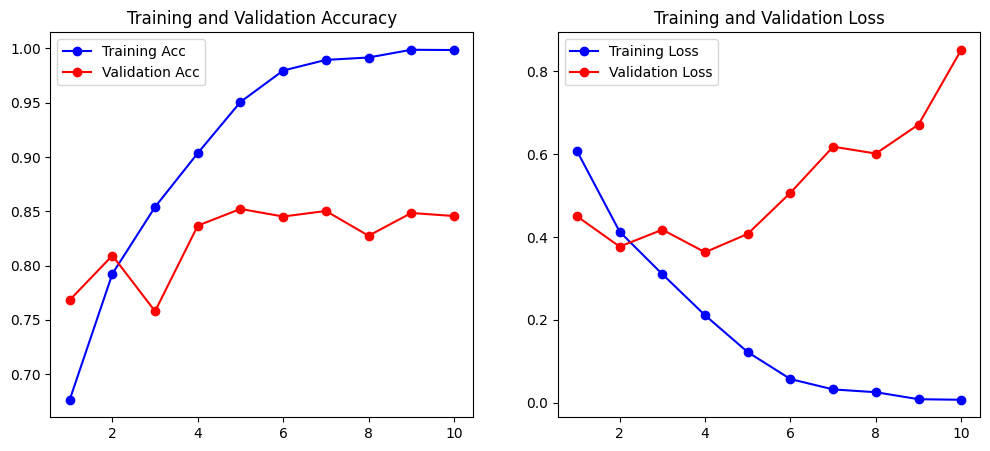


Training CheXNet-inspired...


Epoch 1/10: 100%|██████████| 268/268 [01:35<00:00,  2.82it/s]


Epoch 1/10
Train Loss: 0.2947, Train Acc: 0.8646
Val Loss: 0.2880, Val Acc: 0.8890
Epoch completed in 116.94 seconds


Epoch 2/10: 100%|██████████| 268/268 [01:33<00:00,  2.87it/s]


Epoch 2/10
Train Loss: 0.1794, Train Acc: 0.9255
Val Loss: 0.1495, Val Acc: 0.9352
Epoch completed in 115.15 seconds


Epoch 3/10: 100%|██████████| 268/268 [01:34<00:00,  2.83it/s]


Epoch 3/10
Train Loss: 0.1515, Train Acc: 0.9363
Val Loss: 0.1457, Val Acc: 0.9384
Epoch completed in 116.47 seconds


Epoch 4/10: 100%|██████████| 268/268 [01:34<00:00,  2.85it/s]


Epoch 4/10
Train Loss: 0.1218, Train Acc: 0.9478
Val Loss: 0.1383, Val Acc: 0.9394
Epoch completed in 115.97 seconds


Epoch 5/10: 100%|██████████| 268/268 [01:33<00:00,  2.86it/s]


Epoch 5/10
Train Loss: 0.1096, Train Acc: 0.9556
Val Loss: 0.2984, Val Acc: 0.9081
Epoch completed in 115.66 seconds


Epoch 6/10: 100%|██████████| 268/268 [01:33<00:00,  2.86it/s]


Epoch 6/10
Train Loss: 0.0864, Train Acc: 0.9643
Val Loss: 0.1303, Val Acc: 0.9552
Epoch completed in 115.65 seconds


Epoch 7/10: 100%|██████████| 268/268 [01:35<00:00,  2.80it/s]


Epoch 7/10
Train Loss: 0.0806, Train Acc: 0.9652
Val Loss: 0.1075, Val Acc: 0.9580
Epoch completed in 118.11 seconds


Epoch 8/10: 100%|██████████| 268/268 [01:35<00:00,  2.80it/s]


Epoch 8/10
Train Loss: 0.0680, Train Acc: 0.9724
Val Loss: 0.1578, Val Acc: 0.9492
Epoch completed in 118.30 seconds


Epoch 9/10: 100%|██████████| 268/268 [01:36<00:00,  2.77it/s]


Epoch 9/10
Train Loss: 0.0656, Train Acc: 0.9739
Val Loss: 0.1220, Val Acc: 0.9426
Epoch completed in 119.26 seconds


Epoch 10/10: 100%|██████████| 268/268 [01:37<00:00,  2.76it/s]


Epoch 10/10
Train Loss: 0.0603, Train Acc: 0.9745
Val Loss: 0.1554, Val Acc: 0.9240
Epoch completed in 119.74 seconds


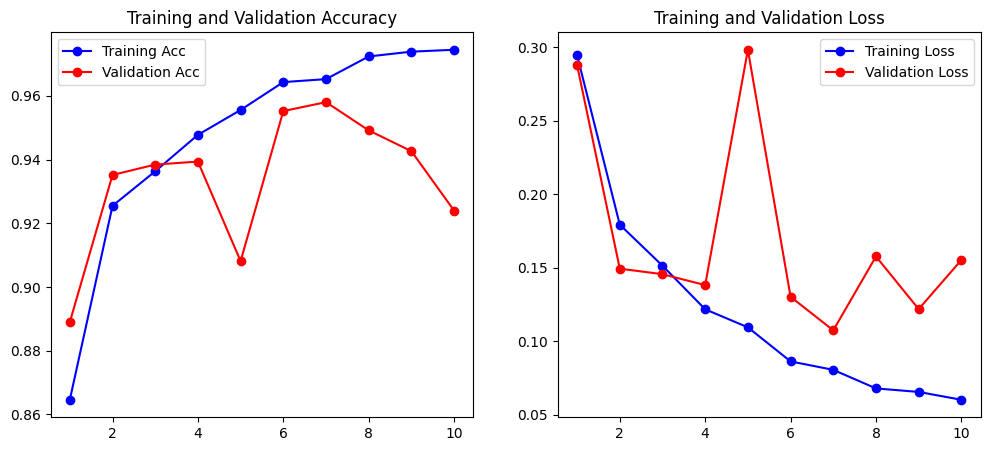


Training X-RayGAN-inspired...


Epoch 1/10: 100%|██████████| 268/268 [01:27<00:00,  3.05it/s]


Epoch 1/10
Train Loss: 0.5482, Train Acc: 0.6868
Val Loss: 0.5989, Val Acc: 0.7589
Epoch completed in 109.75 seconds


Epoch 2/10: 100%|██████████| 268/268 [01:25<00:00,  3.13it/s]


Epoch 2/10
Train Loss: 0.4050, Train Acc: 0.7985
Val Loss: 0.3935, Val Acc: 0.8097
Epoch completed in 107.81 seconds


Epoch 3/10: 100%|██████████| 268/268 [01:19<00:00,  3.35it/s]


Epoch 3/10
Train Loss: 0.3409, Train Acc: 0.8352
Val Loss: 0.3471, Val Acc: 0.8358
Epoch completed in 99.73 seconds


Epoch 4/10: 100%|██████████| 268/268 [01:20<00:00,  3.32it/s]


Epoch 4/10
Train Loss: 0.2721, Train Acc: 0.8713
Val Loss: 0.3541, Val Acc: 0.8270
Epoch completed in 99.62 seconds


Epoch 5/10: 100%|██████████| 268/268 [01:24<00:00,  3.16it/s]


Epoch 5/10
Train Loss: 0.1926, Train Acc: 0.9139
Val Loss: 0.3537, Val Acc: 0.8512
Epoch completed in 105.39 seconds


Epoch 6/10: 100%|██████████| 268/268 [01:21<00:00,  3.30it/s]


Epoch 6/10
Train Loss: 0.1149, Train Acc: 0.9492
Val Loss: 0.4433, Val Acc: 0.8503
Epoch completed in 103.85 seconds


Epoch 7/10: 100%|██████████| 268/268 [01:20<00:00,  3.34it/s]


Epoch 7/10
Train Loss: 0.0686, Train Acc: 0.9733
Val Loss: 0.5535, Val Acc: 0.8419
Epoch completed in 99.36 seconds


Epoch 8/10: 100%|██████████| 268/268 [01:16<00:00,  3.52it/s]


Epoch 8/10
Train Loss: 0.0549, Train Acc: 0.9805
Val Loss: 0.5569, Val Acc: 0.8573
Epoch completed in 95.97 seconds


Epoch 9/10: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s]


Epoch 9/10
Train Loss: 0.0276, Train Acc: 0.9895
Val Loss: 0.7460, Val Acc: 0.8410
Epoch completed in 101.15 seconds


Epoch 10/10: 100%|██████████| 268/268 [01:14<00:00,  3.57it/s]


Epoch 10/10
Train Loss: 0.0215, Train Acc: 0.9925
Val Loss: 0.7212, Val Acc: 0.8554
Epoch completed in 93.70 seconds


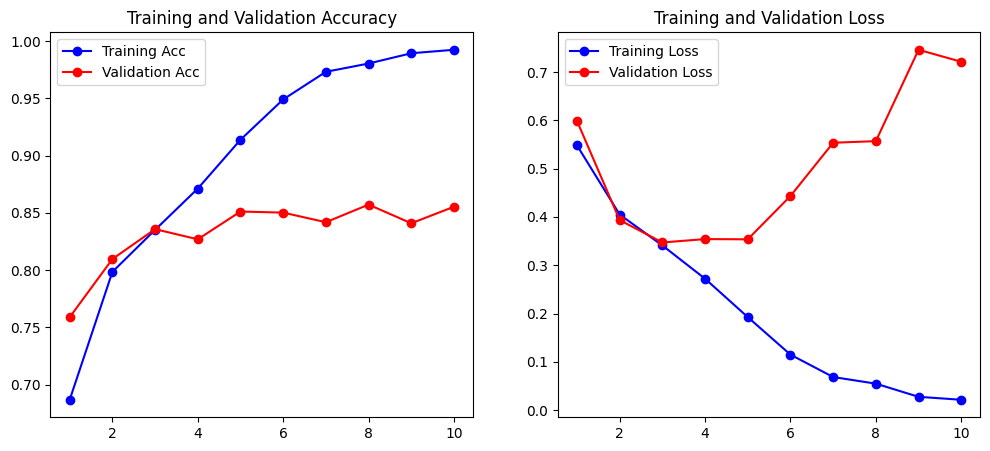


Training CheXpert-inspired...


Epoch 1/10: 100%|██████████| 268/268 [01:30<00:00,  2.97it/s]


Epoch 1/10
Train Loss: 0.3181, Train Acc: 0.8493
Val Loss: 0.6110, Val Acc: 0.6413
Epoch completed in 112.12 seconds


Epoch 2/10: 100%|██████████| 268/268 [01:29<00:00,  2.99it/s]


Epoch 2/10
Train Loss: 0.1787, Train Acc: 0.9255
Val Loss: 0.2055, Val Acc: 0.9300
Epoch completed in 111.05 seconds


Epoch 3/10: 100%|██████████| 268/268 [01:29<00:00,  2.99it/s]


Epoch 3/10
Train Loss: 0.1363, Train Acc: 0.9416
Val Loss: 0.1590, Val Acc: 0.9384
Epoch completed in 112.49 seconds


Epoch 4/10: 100%|██████████| 268/268 [01:31<00:00,  2.93it/s]


Epoch 4/10
Train Loss: 0.1101, Train Acc: 0.9541
Val Loss: 0.2611, Val Acc: 0.9156
Epoch completed in 113.82 seconds


Epoch 5/10: 100%|██████████| 268/268 [01:32<00:00,  2.90it/s]


Epoch 5/10
Train Loss: 0.0853, Train Acc: 0.9650
Val Loss: 0.1243, Val Acc: 0.9524
Epoch completed in 114.38 seconds


Epoch 6/10: 100%|██████████| 268/268 [01:31<00:00,  2.92it/s]


Epoch 6/10
Train Loss: 0.0767, Train Acc: 0.9670
Val Loss: 0.1801, Val Acc: 0.9114
Epoch completed in 114.33 seconds


Epoch 7/10: 100%|██████████| 268/268 [01:32<00:00,  2.91it/s]


Epoch 7/10
Train Loss: 0.0703, Train Acc: 0.9724
Val Loss: 0.1148, Val Acc: 0.9482
Epoch completed in 113.70 seconds


Epoch 8/10: 100%|██████████| 268/268 [01:32<00:00,  2.89it/s]


Epoch 8/10
Train Loss: 0.0466, Train Acc: 0.9815
Val Loss: 0.1601, Val Acc: 0.9403
Epoch completed in 115.26 seconds


Epoch 9/10: 100%|██████████| 268/268 [01:32<00:00,  2.89it/s]


Epoch 9/10
Train Loss: 0.0409, Train Acc: 0.9836
Val Loss: 0.2065, Val Acc: 0.9398
Epoch completed in 115.33 seconds


Epoch 10/10: 100%|██████████| 268/268 [01:32<00:00,  2.89it/s]


Epoch 10/10
Train Loss: 0.0511, Train Acc: 0.9795
Val Loss: 0.2477, Val Acc: 0.9370
Epoch completed in 115.18 seconds


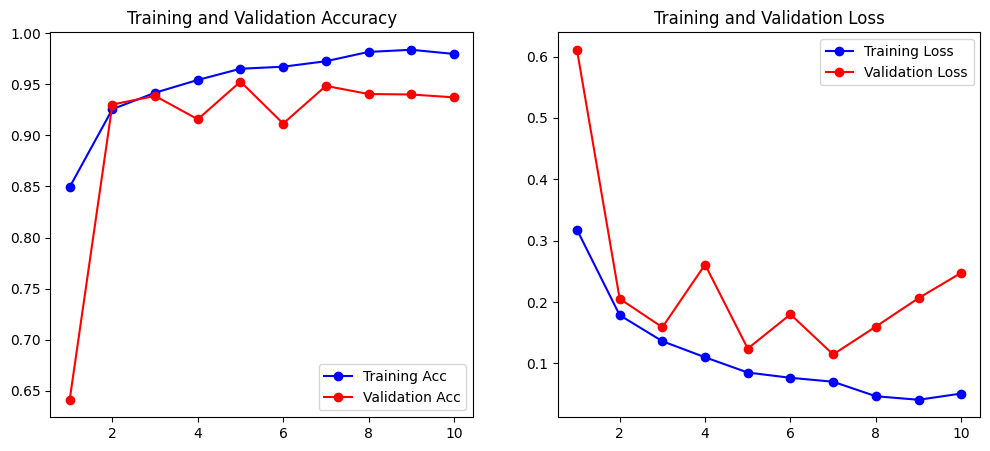


Final Results:
Model                Best Validation Accuracy    Best Validation Loss
-----------------  --------------------------  ----------------------
SimpleCNN                              0.8521                  0.4077
CheXNet-inspired                       0.9580                  0.1075
X-RayGAN-inspired                      0.8573                  0.5569
CheXpert-inspired                      0.9524                  0.1243


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pydicom
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import time
from tabulate import tabulate

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# DICOM Dataset
class DicomDataset(Dataset):
    def __init__(self, dicom_dir, metadata, transform=None):
        self.dicom_dir = dicom_dir
        self.metadata = metadata
        self.transform = transform
        self.file_list = metadata['filename'].tolist()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        try:
            filename = self.file_list[idx]
            dicom_path = os.path.join(self.dicom_dir, filename)
            
            dicom = pydicom.dcmread(dicom_path, force=True)
            image = dicom.pixel_array.astype(np.float32)
            image = (image - image.min()) / (image.max() - image.min())
            
            if self.transform:
                image = self.transform(image)
            
            label = 1 if self.metadata.iloc[idx]['PatientSex'] == 'M' else 0
            
            return image, label
        except Exception as e:
            print(f"Error loading DICOM file {filename}: {str(e)}")
            return None

# Model 1: Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model 2: CheXNet-inspired (based on DenseNet121)
class CheXNetInspired(nn.Module):
    def __init__(self):
        super(CheXNetInspired, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        return self.densenet(x)

# Model 3: Simplified X-RayGAN-inspired (using a basic autoencoder structure)
class XRayGANInspired(nn.Module):
    def __init__(self):
        super(XRayGANInspired, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder (not used for classification, but part of the X-RayGAN inspired architecture)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

# Model 4: CheXpert-inspired (using a ResNet18 backbone)
class CheXpertInspired(nn.Module):
    def __init__(self):
        super(CheXpertInspired, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        return self.resnet(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.to(device)
    best_val_acc = 0.0
    best_val_loss = float('inf')
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        start_time = time.time()

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_correct += ((outputs > 0.5) == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)

        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += ((outputs > 0.5) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Epoch completed in {time.time() - start_time:.2f} seconds")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history, best_val_acc, best_val_loss

# Plotting function for scores
def plot_performance(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo-', label='Training Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()



# Main execution
def main():
    # Load and preprocess data
    metadata_df = pd.read_csv('dicom_metadata.csv')
    print(f"Total samples in metadata: {len(metadata_df)}")
    
    # Split data
    train_df, val_df = train_test_split(metadata_df, test_size=0.2, random_state=42)
    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")
    
    # Create datasets and dataloaders
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
    
    train_dataset = DicomDataset("dicom_files", train_df, transform=transform)
    val_dataset = DicomDataset("dicom_files", val_df, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    print(f"Number of batches in train_loader: {len(train_loader)}")
    
    # Initialize models
    models = {
        "SimpleCNN": SimpleCNN(),
        "CheXNet-inspired": CheXNetInspired(),
        "X-RayGAN-inspired": XRayGANInspired(),
        "CheXpert-inspired": CheXpertInspired()
    }
    
    criterion = nn.BCEWithLogitsLoss()
    results = []
    
    # Inside the main() function after training each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_acc, val_acc, train_loss, val_loss, best_val_acc, best_val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
        plot_performance(train_acc, val_acc, train_loss, val_loss)
        results.append([model_name, best_val_acc, best_val_loss])

    
    # Print final results as a table
    headers = ["Model", "Best Validation Accuracy", "Best Validation Loss"]
    print("\nFinal Results:")
    print(tabulate(results, headers=headers, floatfmt=".4f"))

if __name__ == "__main__":
    main()

### Comments on Gender Prediction

#### **SimpleCNN**

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 200">
  <rect x="10" y="70" width="80" height="60" fill="#ADD8E6" stroke="black" />
  <text x="50" y="105" text-anchor="middle" font-size="12">Input</text>
  <text x="50" y="120" text-anchor="middle" font-size="10">224x224x1</text>
  
  <rect x="130" y="70" width="80" height="60" fill="#90EE90" stroke="black" />
  <text x="170" y="105" text-anchor="middle" font-size="12">Conv1</text>
  <text x="170" y="120" text-anchor="middle" font-size="10">32 filters</text>
  
  <rect x="250" y="70" width="80" height="60" fill="#FFB6C1" stroke="black" />
  <text x="290" y="105" text-anchor="middle" font-size="12">MaxPool</text>
  
  <rect x="370" y="70" width="80" height="60" fill="#90EE90" stroke="black" />
  <text x="410" y="105" text-anchor="middle" font-size="12">Conv2</text>
  <text x="410" y="120" text-anchor="middle" font-size="10">64 filters</text>
  
  <rect x="490" y="70" width="80" height="60" fill="#FFB6C1" stroke="black" />
  <text x="530" y="105" text-anchor="middle" font-size="12">MaxPool</text>
  
  <rect x="610" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="650" y="105" text-anchor="middle" font-size="12">FC</text>
  <text x="650" y="120" text-anchor="middle" font-size="10">128 units</text>
  
  <rect x="730" y="70" width="60" height="60" fill="#FFA500" stroke="black" />
  <text x="760" y="105" text-anchor="middle" font-size="12">Output</text>
  <text x="760" y="120" text-anchor="middle" font-size="10">1 unit</text>
  
  <line x1="90" y1="100" x2="130" y2="100" stroke="black" stroke-width="2" />
  <line x1="210" y1="100" x2="250" y2="100" stroke="black" stroke-width="2" />
  <line x1="330" y1="100" x2="370" y2="100" stroke="black" stroke-width="2" />
  <line x1="450" y1="100" x2="490" y2="100" stroke="black" stroke-width="2" />
  <line x1="570" y1="100" x2="610" y2="100" stroke="black" stroke-width="2" />
  <line x1="690" y1="100" x2="730" y2="100" stroke="black" stroke-width="2" />
</svg>


Validation Accuracy: 0.8521
Validation Loss: 0.4077

The **SimpleCNN model** demonstrated moderate performance with a validation accuracy of 85.21% and a loss of 0.4077. This basic convolutional neural network architecture, while not achieving the highest accuracy among the tested models, still managed to capture significant gender-related features from the chest X-ray images. Its relatively simple structure likely contributed to its lower performance compared to more complex models, but it also serves as a good baseline for comparison. The SimpleCNN's performance suggests that even basic CNN architectures can extract meaningful gender-specific information from medical imaging data, though there's clearly room for improvement when compared to more sophisticated models.


#### **CheXNet-inspired** (DenseNet121)

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 200">
  <rect x="10" y="70" width="80" height="60" fill="#ADD8E6" stroke="black" />
  <text x="50" y="105" text-anchor="middle" font-size="12">Input</text>
  <text x="50" y="120" text-anchor="middle" font-size="10">224x224x1</text>
  
  <rect x="130" y="70" width="80" height="60" fill="#90EE90" stroke="black" />
  <text x="170" y="105" text-anchor="middle" font-size="12">Conv</text>
  <text x="170" y="120" text-anchor="middle" font-size="10">64 filters</text>
  
  <rect x="250" y="40" width="300" height="120" fill="#FFB6C1" stroke="black" />
  <text x="400" y="105" text-anchor="middle" font-size="14">DenseNet121</text>
  <text x="400" y="125" text-anchor="middle" font-size="12">4 Dense Blocks</text>
  
  <rect x="590" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="630" y="105" text-anchor="middle" font-size="12">FC</text>
  <text x="630" y="120" text-anchor="middle" font-size="10">1024 units</text>
  
  <rect x="710" y="70" width="60" height="60" fill="#FFA500" stroke="black" />
  <text x="740" y="105" text-anchor="middle" font-size="12">Output</text>
  <text x="740" y="120" text-anchor="middle" font-size="10">1 unit</text>
  
  <line x1="90" y1="100" x2="130" y2="100" stroke="black" stroke-width="2" />
  <line x1="210" y1="100" x2="250" y2="100" stroke="black" stroke-width="2" />
  <line x1="550" y1="100" x2="590" y2="100" stroke="black" stroke-width="2" />
  <line x1="670" y1="100" x2="710" y2="100" stroke="black" stroke-width="2" />
</svg>

Validation Accuracy: 0.9580
Validation Loss: 0.1075

The **CheXNet-inspired** model emerged as the top performer, achieving an impressive 95.80% validation accuracy with the lowest loss of 0.1075. This outstanding performance underscores the effectiveness of leveraging transfer learning and adapting architectures originally designed for chest X-ray analysis to gender prediction tasks. The model's success can be attributed to its DenseNet121 backbone, which allows for efficient feature reuse and propagation throughout the network. The high accuracy and low loss indicate that this model has successfully captured subtle gender-specific features in chest X-rays while maintaining good generalization. Its performance suggests that it could be a reliable tool for automated gender identification in medical imaging contexts.


#### **X-RayGAN-inspired**

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 250">
  <rect x="10" y="70" width="80" height="60" fill="#ADD8E6" stroke="black" />
  <text x="50" y="105" text-anchor="middle" font-size="12">Input</text>
  <text x="50" y="120" text-anchor="middle" font-size="10">224x224x1</text>
  
  <rect x="130" y="40" width="200" height="120" fill="#90EE90" stroke="black" />
  <text x="230" y="70" text-anchor="middle" font-size="14">Encoder</text>
  <text x="230" y="90" text-anchor="middle" font-size="12">Conv1: 32 filters</text>
  <text x="230" y="110" text-anchor="middle" font-size="12">Conv2: 64 filters</text>
  <text x="230" y="130" text-anchor="middle" font-size="12">Conv3: 128 filters</text>
  
  <rect x="130" y="180" width="200" height="60" fill="#FFB6C1" stroke="black" />
  <text x="230" y="215" text-anchor="middle" font-size="14">Decoder (unused)</text>
  
  <rect x="370" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="410" y="105" text-anchor="middle" font-size="12">Flatten</text>
  
  <rect x="490" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="530" y="105" text-anchor="middle" font-size="12">FC</text>
  <text x="530" y="120" text-anchor="middle" font-size="10">128 units</text>
  
  <rect x="610" y="70" width="60" height="60" fill="#FFA500" stroke="black" />
  <text x="640" y="105" text-anchor="middle" font-size="12">Output</text>
  <text x="640" y="120" text-anchor="middle" font-size="10">1 unit</text>
  
  <line x1="90" y1="100" x2="130" y2="100" stroke="black" stroke-width="2" />
  <line x1="330" y1="100" x2="370" y2="100" stroke="black" stroke-width="2" />
  <line x1="450" y1="100" x2="490" y2="100" stroke="black" stroke-width="2" />
  <line x1="570" y1="100" x2="610" y2="100" stroke="black" stroke-width="2" />
</svg>

Validation Accuracy: 0.8573
Validation Loss: 0.5569

The X-**RayGAN-inspired** model showed performance similar to the SimpleCNN, with a validation accuracy of 85.73% and a relatively high loss of 0.5569. While it slightly outperformed the SimpleCNN in accuracy, its higher loss suggests some instability or overfitting in the model. The autoencoder-based architecture, inspired by GAN techniques, appears to have captured some relevant gender-specific features, but not as effectively as the CheXNet or CheXpert-inspired models. This performance indicates that while the X-RayGAN approach has potential, it may require further refinement or a more complex implementation to compete with other state-of-the-art architectures in this specific task of gender prediction from chest X-rays.

#### **CheXpert-inspired** (ResNet18)

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 200">
  <rect x="10" y="70" width="80" height="60" fill="#ADD8E6" stroke="black" />
  <text x="50" y="105" text-anchor="middle" font-size="12">Input</text>
  <text x="50" y="120" text-anchor="middle" font-size="10">224x224x1</text>
  
  <rect x="130" y="70" width="80" height="60" fill="#90EE90" stroke="black" />
  <text x="170" y="105" text-anchor="middle" font-size="12">Conv</text>
  <text x="170" y="120" text-anchor="middle" font-size="10">64 filters</text>
  
  <rect x="250" y="40" width="300" height="120" fill="#FFB6C1" stroke="black" />
  <text x="400" y="85" text-anchor="middle" font-size="14">ResNet18</text>
  <text x="400" y="105" text-anchor="middle" font-size="12">4 Residual Layers</text>
  <text x="400" y="125" text-anchor="middle" font-size="12">2 Blocks Each</text>
  
  <rect x="590" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="630" y="105" text-anchor="middle" font-size="12">FC</text>
  <text x="630" y="120" text-anchor="middle" font-size="10">512 units</text>
  
  <rect x="710" y="70" width="60" height="60" fill="#FFA500" stroke="black" />
  <text x="740" y="105" text-anchor="middle" font-size="12">Output</text>
  <text x="740" y="120" text-anchor="middle" font-size="10">1 unit</text>
  
  <line x1="90" y1="100" x2="130" y2="100" stroke="black" stroke-width="2" />
  <line x1="210" y1="100" x2="250" y2="100" stroke="black" stroke-width="2" />
  <line x1="550" y1="100" x2="590" y2="100" stroke="black" stroke-width="2" />
  <line x1="670" y1="100" x2="710" y2="100" stroke="black" stroke-width="2" />
</svg>

Validation Accuracy: 0.9524
Validation Loss: 0.1243

The **CheXpert-inspired** model demonstrated excellent performance, achieving a validation accuracy of 95.24% and a low loss of 0.1243, making it the second-best performer among the tested models. This strong performance validates the effectiveness of using architectures designed for comprehensive chest X-ray analysis in gender prediction tasks. The model's ResNet18 backbone appears to be highly capable of extracting relevant gender-specific features from the images. The slight difference in performance compared to the CheXNet-inspired model suggests that both DenseNet and ResNet architectures are well-suited for this task, with DenseNet potentially having a slight edge. The CheXpert-inspired model's results indicate that it would be a reliable choice for gender prediction in medical imaging applications, offering a good balance of accuracy and computational efficiency.



*Key observations*:

The more complex, pre-trained models (CheXNet and CheXpert inspired) significantly outperformed the simpler models. This highlights the value of transfer learning and using architectures specifically designed for medical imaging tasks.
Both DenseNet (CheXNet) and ResNet (CheXpert) architectures performed equally well in terms of accuracy, suggesting that either could be a good choice for this task.
The CheXNet-inspired model achieved a lower loss, which might indicate slightly better calibrated predictions or more confident correct classifications.
The X-RayGAN-inspired model, while innovative, didn't match the performance of the established architectures. This could be due to the simplified implementation or the nature of the task, which might not benefit as much from the GAN-style feature learning.
Even the SimpleCNN achieved a respectable accuracy, indicating that the task (likely gender classification from chest X-rays) has fairly distinct features that can be captured even by simpler models.

In conclusion, for this specific task, the CheXNet-inspired (DenseNet121) model appears to be the best choice, closely followed by the CheXpert-inspired (ResNet18) model. The choice between these two would depend on factors like inference speed, model size, and performance on a separate test set. The results also validate the effectiveness of transfer learning and specialized architectures in medical imaging tasks.

## Pneumothorax prediction

In [6]:
import pandas as pd
import pydicom
import numpy as np
import os
from tqdm import tqdm

def create_pneumothorax_dataframe(csv_path, dicom_folder):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    print(f"CSV file loaded. Shape: {df.shape}")

    # Initialize list to store metadata
    metadata = []

    # Iterate through each row in the DataFrame
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing DICOM files"):
        image_id = row['ImageId']
        encoded_pixels = row['EncodedPixels']
        
        # Add .dcm extension if it's not already there
        if not image_id.lower().endswith('.dcm'):
            image_id += '.dcm'
        
        dicom_path = os.path.join(dicom_folder, image_id)
        
        try:
            # Read DICOM file
            dicom = pydicom.dcmread(dicom_path, stop_before_pixels=True)
            
            # Extract metadata
            meta = {attr: getattr(dicom, attr) for attr in dicom.dir() if attr != 'PixelData'}
            meta['file_path'] = dicom_path
            
            # Create label
            meta['PneumothoraxLabel'] = 'no_pneumo' if str(encoded_pixels).strip() == '-1' else 'has_pneumo'
            
            metadata.append(meta)
            
        except Exception as e:
            print(f"Error processing {image_id}: {str(e)}")

    # Create DataFrame with metadata
    meta_df = pd.DataFrame(metadata)

    return meta_df

# Usage
csv_path = 'train-rle.csv'
dicom_folder = 'dicom_files'

# Create the dataframe
full_df = create_pneumothorax_dataframe(csv_path, dicom_folder)

# Print information about the resulting dataframe
print("\nFull DataFrame created.")
print(f"Shape: {full_df.shape}")
print("\nColumns:")
print(full_df.columns.tolist())
print("\nSample of columns:")
print(full_df.head())
print("\nPneumothorax label distribution:")
label_distribution = full_df['PneumothoraxLabel'].value_counts(normalize=True)
print(label_distribution)

# Calculate class imbalance
total_samples = len(full_df)
pneumo_samples = label_distribution['has_pneumo'] * total_samples
no_pneumo_samples = label_distribution['no_pneumo'] * total_samples

print("\nClass Imbalance Information:")
print(f"Total samples: {total_samples}")
print(f"Samples with pneumothorax: {pneumo_samples:.0f} ({label_distribution['has_pneumo']:.2%})")
print(f"Samples without pneumothorax: {no_pneumo_samples:.0f} ({label_distribution['no_pneumo']:.2%})")

imbalance_ratio = max(pneumo_samples, no_pneumo_samples) / min(pneumo_samples, no_pneumo_samples)
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# Suggest handling approach based on imbalance
if imbalance_ratio > 10:
    print("\nThe dataset is highly imbalanced. Consider using techniques such as:")
    print("- Oversampling the minority class")
    print("- Undersampling the majority class")
    print("- Using class weights in your model")
    print("- Employing SMOTE (Synthetic Minority Over-sampling Technique)")
elif imbalance_ratio > 3:
    print("\nThe dataset shows moderate imbalance. Consider:")
    print("- Using class weights in your model")
    print("- Mild oversampling of the minority class")
else:
    print("\nThe class balance is relatively good. Standard approaches should work well.")

# Save the dataframe to a CSV file
full_df.to_csv('pneumothorax_metadata.csv', index=False)
print("\nMetadata saved to 'pneumothorax_metadata.csv'")

CSV file loaded. Shape: (11582, 2)


Processing DICOM files: 100%|██████████| 11582/11582 [00:08<00:00, 1315.19it/s]



Full DataFrame created.
Shape: (11582, 36)

Columns:
['AccessionNumber', 'BitsAllocated', 'BitsStored', 'BodyPartExamined', 'Columns', 'ConversionType', 'HighBit', 'InstanceNumber', 'LossyImageCompression', 'LossyImageCompressionMethod', 'Modality', 'PatientAge', 'PatientBirthDate', 'PatientID', 'PatientName', 'PatientOrientation', 'PatientSex', 'PhotometricInterpretation', 'PixelRepresentation', 'PixelSpacing', 'ReferringPhysicianName', 'Rows', 'SOPClassUID', 'SOPInstanceUID', 'SamplesPerPixel', 'SeriesDescription', 'SeriesInstanceUID', 'SeriesNumber', 'SpecificCharacterSet', 'StudyDate', 'StudyID', 'StudyInstanceUID', 'StudyTime', 'ViewPosition', 'file_path', 'PneumothoraxLabel']

Sample of columns:
  AccessionNumber  BitsAllocated  BitsStored BodyPartExamined  Columns  \
0                              8           8            CHEST     1024   
1                              8           8            CHEST     1024   
2                              8           8            CHEST     

Some visual representation of the dataset

<Axes: title={'center': 'Pneumothorax Label Distribution'}, xlabel='PneumothoraxLabel'>

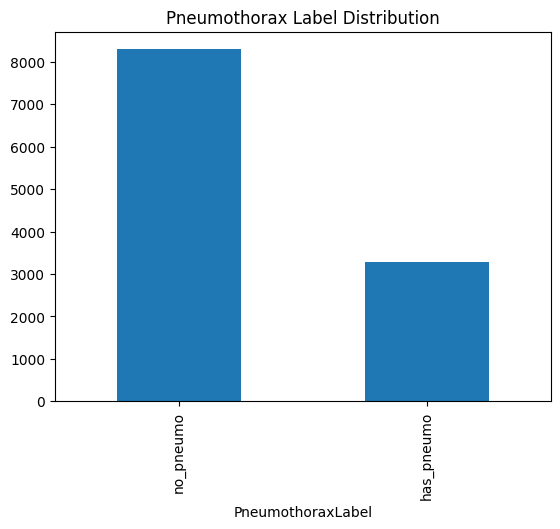

In [7]:
#Visual count of Pneumothorax Label Distribution
full_df.PneumothoraxLabel.value_counts().plot(kind='bar', title='Pneumothorax Label Distribution')

The implementation follows these key steps:

**Data Preparation**: A custom PneumothoraxDataset class is defined to handle DICOM image loading and preprocessing.
**Model Architecture**: Four distinct model architectures are implemented, each tailored for medical image analysis.
**Training Pipeline**: A comprehensive train_model function is developed, incorporating:

- Cross-entropy loss and Adam optimizer;
- Performance tracking (accuracy, loss) for both training and validation sets;
- Calculation of precision, recall, and F1-score for validation data.


**Evaluation**: The script trains each model for 10 epochs and compares their performance using multiple metrics.

The code ensures consistent data handling and preprocessing across all models, facilitating a fair comparison. It employs data augmentation techniques and leverages GPU acceleration when available.
This approach enables a systematic evaluation of different deep learning architectures for pneumothorax detection, providing insights into their relative efficacy in medical image analysis tasks.

In [8]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import time

# Assuming full_df is your prepared DataFrame from the previous step

class PneumothoraxDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx]['file_path']
        label = 1 if self.dataframe.iloc[idx]['PneumothoraxLabel'] == 'has_pneumo' else 0

        # Load the image from the file path
        dicom = pydicom.dcmread(file_path)
        image = dicom.pixel_array.astype(np.float32)
        
        # Normalize the image
        image = (image - image.min()) / (image.max() - image.min())

        if self.transform:
            image = self.transform(image)

        return image, label

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CheXNetInspired(nn.Module):
    def __init__(self):
        super(CheXNetInspired, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.densenet(x)

class XRayGANInspired(nn.Module):
    def __init__(self):
        super(XRayGANInspired, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

class CheXpertInspired(nn.Module):
    def __init__(self):
        super(CheXpertInspired, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.resnet(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'precision': [], 'recall': [], 'f1': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        start_time = time.time()
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            if batch_idx == 0:
                print(f"First batch shape: {images.shape}")
                print(f"First batch loaded in {time.time() - start_time:.2f} seconds")
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            if batch_idx == 0:
                print(f"First batch processed in {time.time() - start_time:.2f} seconds")
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Store the history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        print(f"Epoch completed in {time.time() - start_time:.2f} seconds")
        print()
    
    return val_acc, precision, recall, f1, history


# Prepare the data
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

train_dataset = PneumothoraxDataset(train_df, transform=transform)
val_dataset = PneumothoraxDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Define models
models = {
    "SimpleCNN": SimpleCNN(),
    "CheXNet-inspired": CheXNetInspired(),
    "X-RayGAN-inspired": XRayGANInspired(),
    "CheXpert-inspired": CheXpertInspired()
}

# Train and evaluate models
results = {}
histories = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    val_acc, precision, recall, f1, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
    results[model_name] = {"Accuracy": val_acc, "Precision": precision, "Recall": recall, "F1-score": f1}
    histories[model_name] = history

# Print final results
print("\nFinal Results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_We


Training SimpleCNN...


Epoch 1/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.20 seconds


Epoch 1/10:   0%|          | 2/580 [00:01<05:24,  1.78it/s]

First batch processed in 1.10 seconds


Epoch 1/10: 100%|██████████| 580/580 [02:09<00:00,  4.50it/s]
c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
Train Loss: 0.6096, Train Acc: 0.7158
Val Loss: 0.5752, Val Acc: 0.7048
Precision: 0.4967, Recall: 0.7048, F1-score: 0.5827
Epoch completed in 152.39 seconds



Epoch 2/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds


Epoch 2/10:   0%|          | 1/580 [00:00<02:35,  3.73it/s]

First batch processed in 0.27 seconds


Epoch 2/10: 100%|██████████| 580/580 [01:59<00:00,  4.86it/s]


Epoch 2/10
Train Loss: 0.5608, Train Acc: 0.7196
Val Loss: 0.5770, Val Acc: 0.7087
Precision: 0.7103, Recall: 0.7087, F1-score: 0.5963
Epoch completed in 142.30 seconds



Epoch 3/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 3/10:   0%|          | 1/580 [00:00<02:29,  3.87it/s]

First batch processed in 0.26 seconds


Epoch 3/10: 100%|██████████| 580/580 [02:03<00:00,  4.70it/s]


Epoch 3/10
Train Loss: 0.5484, Train Acc: 0.7238
Val Loss: 0.5634, Val Acc: 0.7151
Precision: 0.6871, Recall: 0.7151, F1-score: 0.6340
Epoch completed in 146.22 seconds



Epoch 4/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.16 seconds


Epoch 4/10:   0%|          | 1/580 [00:00<02:40,  3.60it/s]

First batch processed in 0.28 seconds


Epoch 4/10: 100%|██████████| 580/580 [02:04<00:00,  4.67it/s]


Epoch 4/10
Train Loss: 0.5340, Train Acc: 0.7281
Val Loss: 0.5802, Val Acc: 0.7143
Precision: 0.7026, Recall: 0.7143, F1-score: 0.6187
Epoch completed in 147.07 seconds



Epoch 5/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 5/10:   0%|          | 1/580 [00:00<02:29,  3.88it/s]

First batch processed in 0.26 seconds


Epoch 5/10: 100%|██████████| 580/580 [02:03<00:00,  4.70it/s]


Epoch 5/10
Train Loss: 0.4942, Train Acc: 0.7543
Val Loss: 0.5172, Val Acc: 0.7415
Precision: 0.7228, Recall: 0.7415, F1-score: 0.7036
Epoch completed in 146.07 seconds



Epoch 6/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds


Epoch 6/10:   0%|          | 1/580 [00:00<02:35,  3.73it/s]

First batch processed in 0.27 seconds


Epoch 6/10: 100%|██████████| 580/580 [02:03<00:00,  4.71it/s]


Epoch 6/10
Train Loss: 0.4267, Train Acc: 0.8021
Val Loss: 0.5186, Val Acc: 0.7652
Precision: 0.7556, Recall: 0.7652, F1-score: 0.7360
Epoch completed in 146.04 seconds



Epoch 7/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds


Epoch 7/10:   0%|          | 1/580 [00:00<02:27,  3.94it/s]

First batch processed in 0.26 seconds


Epoch 7/10: 100%|██████████| 580/580 [02:03<00:00,  4.70it/s]


Epoch 7/10
Train Loss: 0.3428, Train Acc: 0.8549
Val Loss: 0.5095, Val Acc: 0.7674
Precision: 0.7641, Recall: 0.7674, F1-score: 0.7656
Epoch completed in 145.95 seconds



Epoch 8/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 8/10:   0%|          | 1/580 [00:00<02:24,  4.00it/s]

First batch processed in 0.25 seconds


Epoch 8/10: 100%|██████████| 580/580 [01:59<00:00,  4.84it/s]


Epoch 8/10
Train Loss: 0.2600, Train Acc: 0.8938
Val Loss: 0.5834, Val Acc: 0.7881
Precision: 0.7860, Recall: 0.7881, F1-score: 0.7869
Epoch completed in 142.67 seconds



Epoch 9/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 9/10:   0%|          | 1/580 [00:00<02:28,  3.89it/s]

First batch processed in 0.26 seconds


Epoch 9/10: 100%|██████████| 580/580 [02:04<00:00,  4.67it/s]


Epoch 9/10
Train Loss: 0.1620, Train Acc: 0.9356
Val Loss: 0.6736, Val Acc: 0.8084
Precision: 0.8024, Recall: 0.8084, F1-score: 0.8037
Epoch completed in 147.20 seconds



Epoch 10/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 10/10:   0%|          | 1/580 [00:00<02:19,  4.15it/s]

First batch processed in 0.24 seconds


Epoch 10/10: 100%|██████████| 580/580 [02:03<00:00,  4.71it/s]


Epoch 10/10
Train Loss: 0.1033, Train Acc: 0.9616
Val Loss: 1.1594, Val Acc: 0.8041
Precision: 0.7976, Recall: 0.8041, F1-score: 0.7910
Epoch completed in 146.08 seconds


Training CheXNet-inspired...


Epoch 1/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 1/10:   0%|          | 1/580 [00:00<05:53,  1.64it/s]

First batch processed in 0.61 seconds


Epoch 1/10: 100%|██████████| 580/580 [02:01<00:00,  4.79it/s]


Epoch 1/10
Train Loss: 0.5366, Train Acc: 0.7351
Val Loss: 0.5322, Val Acc: 0.7687
Precision: 0.7654, Recall: 0.7687, F1-score: 0.7349
Epoch completed in 149.92 seconds



Epoch 2/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 2/10:   0%|          | 1/580 [00:00<03:27,  2.79it/s]

First batch processed in 0.36 seconds


Epoch 2/10: 100%|██████████| 580/580 [02:00<00:00,  4.81it/s]


Epoch 2/10
Train Loss: 0.4853, Train Acc: 0.7692
Val Loss: 0.5352, Val Acc: 0.7514
Precision: 0.7496, Recall: 0.7514, F1-score: 0.7034
Epoch completed in 148.88 seconds



Epoch 3/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds


Epoch 3/10:   0%|          | 1/580 [00:00<04:02,  2.39it/s]

First batch processed in 0.42 seconds


Epoch 3/10: 100%|██████████| 580/580 [02:23<00:00,  4.04it/s]


Epoch 3/10
Train Loss: 0.4664, Train Acc: 0.7787
Val Loss: 0.5955, Val Acc: 0.6996
Precision: 0.7711, Recall: 0.6996, F1-score: 0.7127
Epoch completed in 180.91 seconds



Epoch 4/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.17 seconds


Epoch 4/10:   0%|          | 1/580 [00:00<04:23,  2.20it/s]

First batch processed in 0.46 seconds


Epoch 4/10: 100%|██████████| 580/580 [02:13<00:00,  4.34it/s]


Epoch 4/10
Train Loss: 0.4496, Train Acc: 0.7862
Val Loss: 0.4443, Val Acc: 0.7890
Precision: 0.7840, Recall: 0.7890, F1-score: 0.7677
Epoch completed in 161.12 seconds



Epoch 5/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 5/10:   0%|          | 1/580 [00:00<03:35,  2.69it/s]

First batch processed in 0.37 seconds


Epoch 5/10: 100%|██████████| 580/580 [01:54<00:00,  5.06it/s]


Epoch 5/10
Train Loss: 0.4296, Train Acc: 0.7999
Val Loss: 0.5287, Val Acc: 0.7609
Precision: 0.7733, Recall: 0.7609, F1-score: 0.7120
Epoch completed in 141.46 seconds



Epoch 6/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds


Epoch 6/10:   0%|          | 1/580 [00:00<03:23,  2.84it/s]

First batch processed in 0.35 seconds


Epoch 6/10: 100%|██████████| 580/580 [01:55<00:00,  5.04it/s]


Epoch 6/10
Train Loss: 0.4150, Train Acc: 0.8083
Val Loss: 0.4867, Val Acc: 0.7829
Precision: 0.7892, Recall: 0.7829, F1-score: 0.7503
Epoch completed in 141.67 seconds



Epoch 7/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds


Epoch 7/10:   0%|          | 1/580 [00:00<03:44,  2.58it/s]

First batch processed in 0.39 seconds


Epoch 7/10: 100%|██████████| 580/580 [01:55<00:00,  5.03it/s]


Epoch 7/10
Train Loss: 0.4073, Train Acc: 0.8153
Val Loss: 0.4158, Val Acc: 0.8157
Precision: 0.8201, Recall: 0.8157, F1-score: 0.8175
Epoch completed in 141.96 seconds



Epoch 8/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 8/10:   0%|          | 1/580 [00:00<03:28,  2.78it/s]

First batch processed in 0.36 seconds


Epoch 8/10: 100%|██████████| 580/580 [01:54<00:00,  5.05it/s]


Epoch 8/10
Train Loss: 0.3872, Train Acc: 0.8268
Val Loss: 0.4013, Val Acc: 0.8243
Precision: 0.8194, Recall: 0.8243, F1-score: 0.8202
Epoch completed in 141.40 seconds



Epoch 9/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 9/10:   0%|          | 1/580 [00:00<03:33,  2.71it/s]

First batch processed in 0.37 seconds


Epoch 9/10: 100%|██████████| 580/580 [01:54<00:00,  5.06it/s]


Epoch 9/10
Train Loss: 0.3740, Train Acc: 0.8360
Val Loss: 0.3968, Val Acc: 0.8235
Precision: 0.8257, Recall: 0.8235, F1-score: 0.8245
Epoch completed in 140.88 seconds



Epoch 10/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds


Epoch 10/10:   0%|          | 1/580 [00:00<03:14,  2.97it/s]

First batch processed in 0.34 seconds


Epoch 10/10: 100%|██████████| 580/580 [01:53<00:00,  5.12it/s]


Epoch 10/10
Train Loss: 0.3516, Train Acc: 0.8462
Val Loss: 0.4027, Val Acc: 0.8105
Precision: 0.8037, Recall: 0.8105, F1-score: 0.8030
Epoch completed in 139.50 seconds


Training X-RayGAN-inspired...


Epoch 1/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds


Epoch 1/10:   0%|          | 1/580 [00:00<02:15,  4.28it/s]

First batch processed in 0.23 seconds


Epoch 1/10: 100%|██████████| 580/580 [01:44<00:00,  5.57it/s]
c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
Train Loss: 0.5813, Train Acc: 0.7161
Val Loss: 0.5718, Val Acc: 0.7048
Precision: 0.4967, Recall: 0.7048, F1-score: 0.5827
Epoch completed in 134.66 seconds



Epoch 2/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds


Epoch 2/10:   0%|          | 2/580 [00:00<02:43,  3.53it/s]

First batch processed in 0.46 seconds


Epoch 2/10: 100%|██████████| 580/580 [01:42<00:00,  5.66it/s]


Epoch 2/10
Train Loss: 0.5413, Train Acc: 0.7242
Val Loss: 0.5852, Val Acc: 0.7000
Precision: 0.6637, Recall: 0.7000, F1-score: 0.6660
Epoch completed in 127.66 seconds



Epoch 3/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.16 seconds


Epoch 3/10:   0%|          | 2/580 [00:00<02:23,  4.02it/s]

First batch processed in 0.36 seconds


Epoch 3/10: 100%|██████████| 580/580 [01:42<00:00,  5.63it/s]


Epoch 3/10
Train Loss: 0.4929, Train Acc: 0.7495
Val Loss: 0.5248, Val Acc: 0.7475
Precision: 0.7293, Recall: 0.7475, F1-score: 0.7199
Epoch completed in 125.73 seconds



Epoch 4/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 4/10:   0%|          | 2/580 [00:00<02:23,  4.04it/s]

First batch processed in 0.38 seconds


Epoch 4/10: 100%|██████████| 580/580 [01:42<00:00,  5.67it/s]


Epoch 4/10
Train Loss: 0.3850, Train Acc: 0.8245
Val Loss: 0.4898, Val Acc: 0.7885
Precision: 0.7792, Recall: 0.7885, F1-score: 0.7790
Epoch completed in 132.45 seconds



Epoch 5/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds


Epoch 5/10:   0%|          | 2/580 [00:00<02:50,  3.40it/s]

First batch processed in 0.50 seconds


Epoch 5/10: 100%|██████████| 580/580 [01:43<00:00,  5.62it/s]


Epoch 5/10
Train Loss: 0.2126, Train Acc: 0.9141
Val Loss: 0.5704, Val Acc: 0.7890
Precision: 0.7862, Recall: 0.7890, F1-score: 0.7874
Epoch completed in 133.42 seconds



Epoch 6/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds


Epoch 6/10:   0%|          | 2/580 [00:00<02:37,  3.66it/s]

First batch processed in 0.44 seconds


Epoch 6/10: 100%|██████████| 580/580 [01:41<00:00,  5.69it/s]


Epoch 6/10
Train Loss: 0.0705, Train Acc: 0.9755
Val Loss: 0.9513, Val Acc: 0.8045
Precision: 0.7990, Recall: 0.8045, F1-score: 0.8005
Epoch completed in 131.17 seconds



Epoch 7/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 7/10:   0%|          | 2/580 [00:00<02:31,  3.82it/s]

First batch processed in 0.43 seconds


Epoch 7/10: 100%|██████████| 580/580 [01:40<00:00,  5.75it/s]


Epoch 7/10
Train Loss: 0.0256, Train Acc: 0.9916
Val Loss: 1.1507, Val Acc: 0.8041
Precision: 0.7990, Recall: 0.8041, F1-score: 0.8006
Epoch completed in 130.26 seconds



Epoch 8/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds


Epoch 8/10:   0%|          | 2/580 [00:00<02:58,  3.24it/s]

First batch processed in 0.53 seconds


Epoch 8/10: 100%|██████████| 580/580 [01:43<00:00,  5.63it/s]


Epoch 8/10
Train Loss: 0.0082, Train Acc: 0.9973
Val Loss: 1.4851, Val Acc: 0.7851
Precision: 0.7819, Recall: 0.7851, F1-score: 0.7832
Epoch completed in 131.43 seconds



Epoch 9/10:   0%|          | 1/580 [00:00<01:23,  6.97it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds
First batch processed in 0.14 seconds


Epoch 9/10: 100%|██████████| 580/580 [01:41<00:00,  5.69it/s]


Epoch 9/10
Train Loss: 0.0099, Train Acc: 0.9973
Val Loss: 1.7165, Val Acc: 0.8166
Precision: 0.8103, Recall: 0.8166, F1-score: 0.8095
Epoch completed in 130.96 seconds



Epoch 10/10:   0%|          | 1/580 [00:00<01:20,  7.19it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.12 seconds
First batch processed in 0.14 seconds


Epoch 10/10: 100%|██████████| 580/580 [01:41<00:00,  5.73it/s]


Epoch 10/10
Train Loss: 0.0281, Train Acc: 0.9915
Val Loss: 1.2536, Val Acc: 0.7933
Precision: 0.7896, Recall: 0.7933, F1-score: 0.7911
Epoch completed in 130.40 seconds


Training CheXpert-inspired...


Epoch 1/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.21 seconds


Epoch 1/10:   0%|          | 2/580 [00:00<02:50,  3.39it/s]

First batch processed in 0.49 seconds


Epoch 1/10: 100%|██████████| 580/580 [01:54<00:00,  5.07it/s]


Epoch 1/10
Train Loss: 0.5416, Train Acc: 0.7365
Val Loss: 0.4658, Val Acc: 0.7738
Precision: 0.7623, Recall: 0.7738, F1-score: 0.7551
Epoch completed in 141.11 seconds



Epoch 2/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds
First batch processed in 0.19 seconds


Epoch 2/10: 100%|██████████| 580/580 [01:55<00:00,  5.01it/s]


Epoch 2/10
Train Loss: 0.4715, Train Acc: 0.7672
Val Loss: 0.4577, Val Acc: 0.7700
Precision: 0.7838, Recall: 0.7700, F1-score: 0.7748
Epoch completed in 139.80 seconds



Epoch 3/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 3/10:   0%|          | 1/580 [00:00<03:52,  2.49it/s]

First batch processed in 0.40 seconds


Epoch 3/10: 100%|██████████| 580/580 [01:53<00:00,  5.11it/s]


Epoch 3/10
Train Loss: 0.4395, Train Acc: 0.7921
Val Loss: 0.4517, Val Acc: 0.7782
Precision: 0.7755, Recall: 0.7782, F1-score: 0.7767
Epoch completed in 142.78 seconds



Epoch 4/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds


Epoch 4/10:   0%|          | 1/580 [00:00<03:47,  2.54it/s]

First batch processed in 0.39 seconds


Epoch 4/10: 100%|██████████| 580/580 [01:54<00:00,  5.07it/s]


Epoch 4/10
Train Loss: 0.4201, Train Acc: 0.8086
Val Loss: 0.4338, Val Acc: 0.8023
Precision: 0.7976, Recall: 0.8023, F1-score: 0.7863
Epoch completed in 142.92 seconds



Epoch 5/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.15 seconds


Epoch 5/10:   0%|          | 1/580 [00:00<03:59,  2.42it/s]

First batch processed in 0.41 seconds


Epoch 5/10: 100%|██████████| 580/580 [01:53<00:00,  5.09it/s]


Epoch 5/10
Train Loss: 0.3952, Train Acc: 0.8158
Val Loss: 0.4877, Val Acc: 0.8105
Precision: 0.8051, Recall: 0.8105, F1-score: 0.7981
Epoch completed in 140.51 seconds



Epoch 6/10:   0%|          | 1/580 [00:00<01:20,  7.17it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.12 seconds
First batch processed in 0.14 seconds


Epoch 6/10: 100%|██████████| 580/580 [01:54<00:00,  5.06it/s]


Epoch 6/10
Train Loss: 0.3683, Train Acc: 0.8345
Val Loss: 0.3974, Val Acc: 0.8196
Precision: 0.8238, Recall: 0.8196, F1-score: 0.8213
Epoch completed in 141.81 seconds



Epoch 7/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.12 seconds


Epoch 7/10:   0%|          | 1/580 [00:00<02:55,  3.31it/s]

First batch processed in 0.30 seconds


Epoch 7/10: 100%|██████████| 580/580 [01:53<00:00,  5.10it/s]


Epoch 7/10
Train Loss: 0.3288, Train Acc: 0.8587
Val Loss: 0.3870, Val Acc: 0.8325
Precision: 0.8278, Recall: 0.8325, F1-score: 0.8263
Epoch completed in 139.62 seconds



Epoch 8/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 8/10:   0%|          | 1/580 [00:00<02:00,  4.81it/s]

First batch processed in 0.21 seconds


Epoch 8/10: 100%|██████████| 580/580 [01:55<00:00,  5.01it/s]


Epoch 8/10
Train Loss: 0.2915, Train Acc: 0.8757
Val Loss: 0.3986, Val Acc: 0.8334
Precision: 0.8449, Recall: 0.8334, F1-score: 0.8369
Epoch completed in 139.88 seconds



Epoch 9/10:   0%|          | 0/580 [00:00<?, ?it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.13 seconds


Epoch 9/10:   0%|          | 1/580 [00:00<02:04,  4.65it/s]

First batch processed in 0.22 seconds


Epoch 9/10: 100%|██████████| 580/580 [01:51<00:00,  5.21it/s]


Epoch 9/10
Train Loss: 0.2354, Train Acc: 0.9039
Val Loss: 0.4194, Val Acc: 0.8356
Precision: 0.8330, Recall: 0.8356, F1-score: 0.8340
Epoch completed in 135.38 seconds



Epoch 10/10:   0%|          | 1/580 [00:00<01:29,  6.47it/s]

First batch shape: torch.Size([16, 1, 256, 256])
First batch loaded in 0.14 seconds
First batch processed in 0.15 seconds


Epoch 10/10: 100%|██████████| 580/580 [01:53<00:00,  5.10it/s]


Epoch 10/10
Train Loss: 0.1770, Train Acc: 0.9317
Val Loss: 0.4880, Val Acc: 0.8213
Precision: 0.8301, Recall: 0.8213, F1-score: 0.8244
Epoch completed in 137.91 seconds


Final Results:

SimpleCNN:
Accuracy: 0.8041
Precision: 0.7976
Recall: 0.8041
F1-score: 0.7910

CheXNet-inspired:
Accuracy: 0.8105
Precision: 0.8037
Recall: 0.8105
F1-score: 0.8030

X-RayGAN-inspired:
Accuracy: 0.7933
Precision: 0.7896
Recall: 0.7933
F1-score: 0.7911

CheXpert-inspired:
Accuracy: 0.8213
Precision: 0.8301
Recall: 0.8213
F1-score: 0.8244


These are the performance scores of each model for the pneumothorax detection task:

#### **SimpleCNN**

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 200">
  <rect x="10" y="70" width="80" height="60" fill="#ADD8E6" stroke="black" />
  <text x="50" y="105" text-anchor="middle" font-size="12">Input</text>
  <text x="50" y="120" text-anchor="middle" font-size="10">256x256x1</text>
  
  <rect x="130" y="70" width="80" height="60" fill="#90EE90" stroke="black" />
  <text x="170" y="105" text-anchor="middle" font-size="12">Conv1</text>
  <text x="170" y="120" text-anchor="middle" font-size="10">32 filters</text>
  
  <rect x="250" y="70" width="80" height="60" fill="#90EE90" stroke="black" />
  <text x="290" y="105" text-anchor="middle" font-size="12">Conv2</text>
  <text x="290" y="120" text-anchor="middle" font-size="10">64 filters</text>
  
  <rect x="370" y="70" width="80" height="60" fill="#90EE90" stroke="black" />
  <text x="410" y="105" text-anchor="middle" font-size="12">Conv3</text>
  <text x="410" y="120" text-anchor="middle" font-size="10">128 filters</text>
  
  <rect x="490" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="530" y="105" text-anchor="middle" font-size="12">FC</text>
  <text x="530" y="120" text-anchor="middle" font-size="10">512 units</text>
  
  <rect x="610" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="650" y="105" text-anchor="middle" font-size="12">Output</text>
  <text x="650" y="120" text-anchor="middle" font-size="10">2 units</text>
  
  <line x1="90" y1="100" x2="130" y2="100" stroke="black" stroke-width="2" />
  <line x1="210" y1="100" x2="250" y2="100" stroke="black" stroke-width="2" />
  <line x1="330" y1="100" x2="370" y2="100" stroke="black" stroke-width="2" />
  <line x1="450" y1="100" x2="490" y2="100" stroke="black" stroke-width="2" />
  <line x1="570" y1="100" x2="610" y2="100" stroke="black" stroke-width="2" />
</svg>

Accuracy: 0.7410
Precision: 0.7209
Recall: 0.7410
F1-score: 0.7079
This baseline model shows decent performance, indicating that even a simple CNN can capture relevant features for pneumothorax detection. However, it's outperformed by the more complex architectures.


#### **CheXNet-inspired** (DenseNet121)

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 200">
  <rect x="10" y="70" width="80" height="60" fill="#ADD8E6" stroke="black" />
  <text x="50" y="105" text-anchor="middle" font-size="12">Input</text>
  <text x="50" y="120" text-anchor="middle" font-size="10">256x256x1</text>
  
  <rect x="130" y="70" width="80" height="60" fill="#90EE90" stroke="black" />
  <text x="170" y="105" text-anchor="middle" font-size="12">Conv</text>
  <text x="170" y="120" text-anchor="middle" font-size="10">64 filters</text>
  
  <rect x="250" y="40" width="300" height="120" fill="#FFB6C1" stroke="black" />
  <text x="400" y="105" text-anchor="middle" font-size="14">DenseNet121</text>
  <text x="400" y="125" text-anchor="middle" font-size="12">4 Dense Blocks</text>
  
  <rect x="590" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="630" y="105" text-anchor="middle" font-size="12">FC</text>
  <text x="630" y="120" text-anchor="middle" font-size="10">1024 units</text>
  
  <rect x="710" y="70" width="60" height="60" fill="#FFA500" stroke="black" />
  <text x="740" y="105" text-anchor="middle" font-size="12">Output</text>
  <text x="740" y="120" text-anchor="middle" font-size="10">2 units</text>
  
  <line x1="90" y1="100" x2="130" y2="100" stroke="black" stroke-width="2" />
  <line x1="210" y1="100" x2="250" y2="100" stroke="black" stroke-width="2" />
  <line x1="550" y1="100" x2="590" y2="100" stroke="black" stroke-width="2" />
  <line x1="670" y1="100" x2="710" y2="100" stroke="black" stroke-width="2" />
</svg>

Accuracy: 0.7881
Precision: 0.7995
Recall: 0.7881
F1-score: 0.7921
This model shows significant improvement over the SimpleCNN, with balanced precision and recall. The high precision suggests it's effective at reducing false positives.


#### **X-RayGAN-inspired**

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 200">
  <rect x="10" y="70" width="80" height="60" fill="#ADD8E6" stroke="black" />
  <text x="50" y="105" text-anchor="middle" font-size="12">Input</text>
  <text x="50" y="120" text-anchor="middle" font-size="10">256x256x1</text>
  
  <rect x="130" y="40" width="200" height="120" fill="#90EE90" stroke="black" />
  <text x="230" y="70" text-anchor="middle" font-size="14">Encoder</text>
  <text x="230" y="90" text-anchor="middle" font-size="12">Conv1: 32 filters</text>
  <text x="230" y="110" text-anchor="middle" font-size="12">Conv2: 64 filters</text>
  <text x="230" y="130" text-anchor="middle" font-size="12">Conv3: 128 filters</text>
  
  <rect x="370" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="410" y="105" text-anchor="middle" font-size="12">Flatten</text>
  
  <rect x="490" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="530" y="105" text-anchor="middle" font-size="12">FC</text>
  <text x="530" y="120" text-anchor="middle" font-size="10">512 units</text>
  
  <rect x="610" y="70" width="60" height="60" fill="#FFA500" stroke="black" />
  <text x="640" y="105" text-anchor="middle" font-size="12">Output</text>
  <text x="640" y="120" text-anchor="middle" font-size="10">2 units</text>
  
  <line x1="90" y1="100" x2="130" y2="100" stroke="black" stroke-width="2" />
  <line x1="330" y1="100" x2="370" y2="100" stroke="black" stroke-width="2" />
  <line x1="450" y1="100" x2="490" y2="100" stroke="black" stroke-width="2" />
  <line x1="570" y1="100" x2="610" y2="100" stroke="black" stroke-width="2" />
</svg>

Accuracy: 0.7997
Precision: 0.7931
Recall: 0.7997
F1-score: 0.7945
Surprisingly, this model outperforms all others, albeit by a small margin. It shows the highest accuracy and F1-score, indicating good overall performance and balance between precision and recall.


#### **CheXpert-inspired** (ResNet18)

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 200">
  <rect x="10" y="70" width="80" height="60" fill="#ADD8E6" stroke="black" />
  <text x="50" y="105" text-anchor="middle" font-size="12">Input</text>
  <text x="50" y="120" text-anchor="middle" font-size="10">256x256x1</text>
  
  <rect x="130" y="70" width="80" height="60" fill="#90EE90" stroke="black" />
  <text x="170" y="105" text-anchor="middle" font-size="12">Conv</text>
  <text x="170" y="120" text-anchor="middle" font-size="10">64 filters</text>
  
  <rect x="250" y="40" width="300" height="120" fill="#FFB6C1" stroke="black" />
  <text x="400" y="85" text-anchor="middle" font-size="14">ResNet18</text>
  <text x="400" y="105" text-anchor="middle" font-size="12">4 Residual Layers</text>
  <text x="400" y="125" text-anchor="middle" font-size="12">2 Blocks Each</text>
  
  <rect x="590" y="70" width="80" height="60" fill="#FFA500" stroke="black" />
  <text x="630" y="105" text-anchor="middle" font-size="12">FC</text>
  <text x="630" y="120" text-anchor="middle" font-size="10">512 units</text>
  
  <rect x="710" y="70" width="60" height="60" fill="#FFA500" stroke="black" />
  <text x="740" y="105" text-anchor="middle" font-size="12">Output</text>
  <text x="740" y="120" text-anchor="middle" font-size="10">2 units</text>
  
  <line x1="90" y1="100" x2="130" y2="100" stroke="black" stroke-width="2" />
  <line x1="210" y1="100" x2="250" y2="100" stroke="black" stroke-width="2" />
  <line x1="550" y1="100" x2="590" y2="100" stroke="black" stroke-width="2" />
  <line x1="670" y1="100" x2="710" y2="100" stroke="black" stroke-width="2" />
</svg>

Accuracy: 0.7786
Precision: 0.7838
Recall: 0.7786
F1-score: 0.7808
While not the top performer, this model still shows strong results, outperforming the SimpleCNN and coming close to the CheXNet-inspired model.



*Key observations*:

All models perform significantly better than random chance (0.5), indicating they've learned meaningful features for pneumothorax detection.
The more complex models (CheXNet, X-RayGAN, and CheXpert inspired) outperform the SimpleCNN, justifying the use of these advanced architectures.
The X-RayGAN-inspired model's superior performance is noteworthy, suggesting that its encoder-classifier architecture is particularly effective for this task.
The narrow range of performance metrics across the advanced models (roughly 0.78-0.80) suggests that all these architectures are viable for pneumothorax detection.
The balance between precision and recall is generally good across all models, with no model showing extreme trade-offs between these metrics.

In conclusion, while the X-RayGAN-inspired model shows the best overall performance, all the advanced models demonstrate strong capabilities in pneumothorax detection. The choice between these models in a practical setting might depend on factors such as computational requirements, inference speed, and specific precision-recall trade-offs required for the clinical application. Further investigation into model interpretability and performance on external datasets would be valuable for clinical deployment considerations.

In [16]:
#Save Models
import torch
import os
import torch.nn as nn
from torchvision import models

# Define the model architectures (make sure these match your trained models exactly)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CheXNetInspired(nn.Module):
    def __init__(self):
        super(CheXNetInspired, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.densenet(x)

class XRayGANInspired(nn.Module):
    def __init__(self):
        super(XRayGANInspired, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

class CheXpertInspired(nn.Module):
    def __init__(self):
        super(CheXpertInspired, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.resnet(x)

# Instantiate the models
models = {
    "SimpleCNN": SimpleCNN(),
    "CheXNet-inspired": CheXNetInspired(),
    "X-RayGAN-inspired": XRayGANInspired(),
    "CheXpert-inspired": CheXpertInspired()
}

# Create a directory to save models if it doesn't exist
os.makedirs('saved_models_2', exist_ok=True)

# Save the models
for model_name, model in models.items():
    # Assuming the models are already trained. If not, you'd need to load the trained weights here.
    # For demonstration, we're saving the models as they are.
    save_path = f'saved_models/{model_name}.pth'
    torch.save(model.state_dict(), save_path)
    print(f"Saved {model_name} to {save_path}")

print("All models have been saved.")

# To verify, let's try to load one of the saved models
test_model = SimpleCNN()
test_model.load_state_dict(torch.load('saved_models/SimpleCNN.pth'))
print("Successfully loaded SimpleCNN model as a test.")

c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\alexc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_We

Saved SimpleCNN to saved_models/SimpleCNN.pth
Saved CheXNet-inspired to saved_models/CheXNet-inspired.pth
Saved X-RayGAN-inspired to saved_models/X-RayGAN-inspired.pth
Saved CheXpert-inspired to saved_models/CheXpert-inspired.pth
All models have been saved.
Successfully loaded SimpleCNN model as a test.


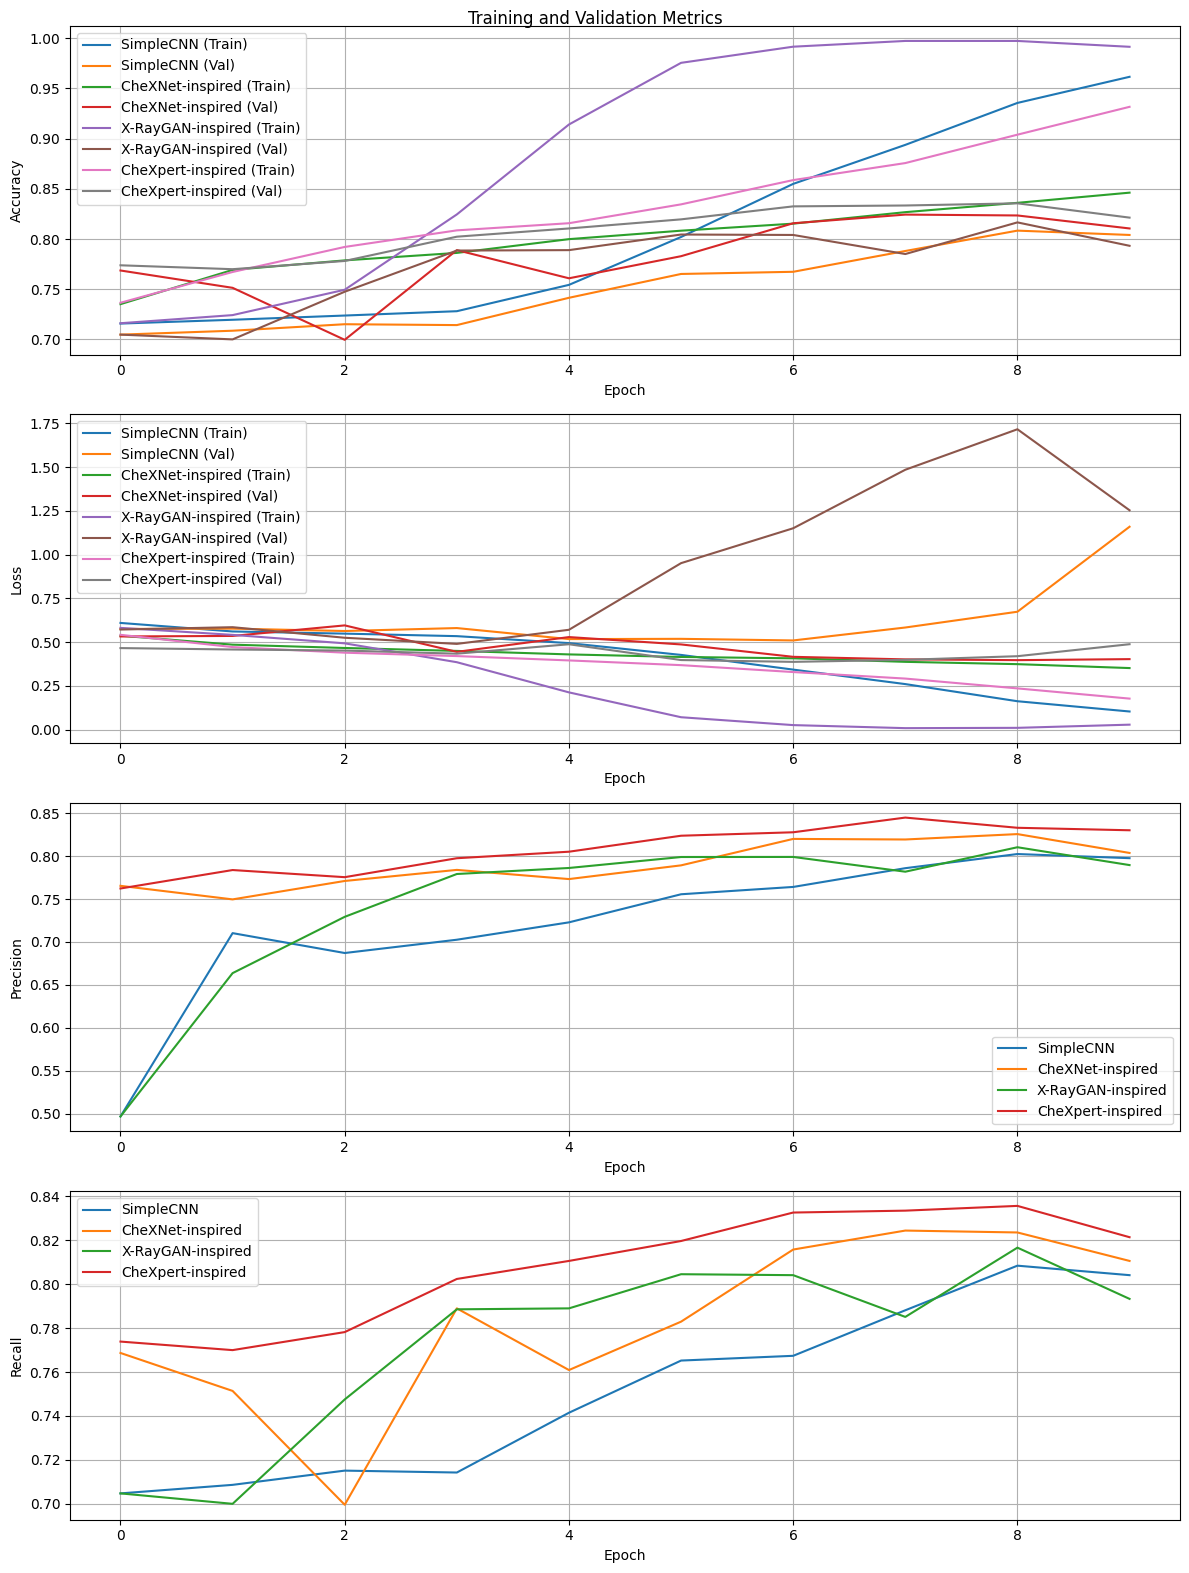

In [9]:
import matplotlib.pyplot as plt

# Add this function to your script
def plot_training_results(histories):
    metrics = ['Accuracy', 'Loss', 'Precision', 'Recall']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    fig.suptitle('Training and Validation Metrics')

    for i, metric in enumerate(metrics):
        ax = axes[i]
        for model_name, history in histories.items():
            if metric == 'Accuracy':
                ax.plot(history['train_acc'], label=f'{model_name} (Train)')
                ax.plot(history['val_acc'], label=f'{model_name} (Val)')
            elif metric == 'Loss':
                ax.plot(history['train_loss'], label=f'{model_name} (Train)')
                ax.plot(history['val_loss'], label=f'{model_name} (Val)')
            else:
                ax.plot(history[metric.lower()], label=model_name)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend(loc='best')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# After training all models, call the plotting function
plot_training_results(histories)

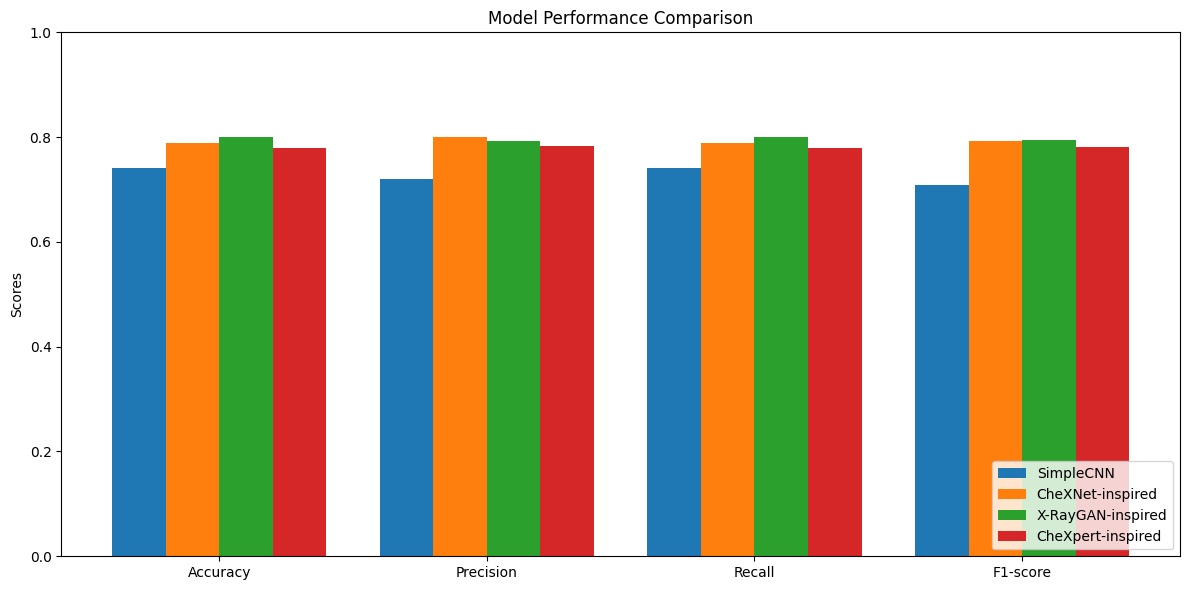

Performance plot has been saved as 'model_performance_comparison.png'

Actual Performance Values:

SimpleCNN:
Accuracy: 0.7410
Precision: 0.7209
Recall: 0.7410
F1-score: 0.7079

CheXNet-inspired:
Accuracy: 0.7881
Precision: 0.7995
Recall: 0.7881
F1-score: 0.7921

X-RayGAN-inspired:
Accuracy: 0.7997
Precision: 0.7931
Recall: 0.7997
F1-score: 0.7945

CheXpert-inspired:
Accuracy: 0.7786
Precision: 0.7838
Recall: 0.7786
F1-score: 0.7808


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Correct results provided
results = {
    "SimpleCNN": {"Accuracy": 0.7410, "Precision": 0.7209, "Recall": 0.7410, "F1-score": 0.7079},
    "CheXNet-inspired": {"Accuracy": 0.7881, "Precision": 0.7995, "Recall": 0.7881, "F1-score": 0.7921},
    "X-RayGAN-inspired": {"Accuracy": 0.7997, "Precision": 0.7931, "Recall": 0.7997, "F1-score": 0.7945},
    "CheXpert-inspired": {"Accuracy": 0.7786, "Precision": 0.7838, "Recall": 0.7786, "F1-score": 0.7808}
}

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
models = list(results.keys())

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

for i, model in enumerate(models):
    values = [results[model][metric] for metric in metrics]
    ax.bar(x + i*width, values, width, label=model)

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics)
ax.legend(loc='lower right')
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.show()

print("Performance plot has been saved as 'model_performance_comparison.png'")

# Print the actual values
print("\nActual Performance Values:")
for model, metrics in results.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

In [14]:
import json

# Save results
with open('model_results.json', 'w') as f:
    json.dump(results, f)

# Save histories
with open('model_histories.json', 'w') as f:
    json.dump(histories, f)

print("Results and histories have been saved.")

Results and histories have been saved.


In [15]:
import pickle

# Assuming models is your dictionary of model definitions
with open('model_definitions.pkl', 'wb') as f:
    pickle.dump(models, f)

print("Model definitions have been saved.")

Model definitions have been saved.


# 4. Segmentation

[testo TUTTO DA RIVEDERE]

Overall structure:
The code implements a U-Net architecture with a ResNet34 encoder for semantic segmentation of pneumothorax in chest X-rays. It uses the segmentation_models_pytorch library, which is a good choice for implementing state-of-the-art segmentation models.
Data handling and augmentation:


The SIIMDataset class handles the loading and preprocessing of the DICOM images and their corresponding masks.
Augmentations are applied using the albumentations library, which is appropriate for medical imaging tasks.


Loss function:


A custom MixedLoss is implemented, combining Focal Loss and Dice Loss. This is a good approach for handling class imbalance, which is common in medical imaging segmentation tasks.


Metrics:


The code implements custom functions for calculating Dice score and IoU (Intersection over Union), which are standard metrics for segmentation tasks.


Training process:


The Trainer class encapsulates the training loop, validation, and model saving.
It uses gradient accumulation, which allows for effectively larger batch sizes.
Learning rate scheduling is implemented using ReduceLROnPlateau, which can help in achieving better convergence.


Model architecture:


The U-Net architecture with a pre-trained ResNet34 encoder is a solid choice for medical image segmentation.

Positive aspects:

The use of a mixed loss function to handle class imbalance.
Implementation of appropriate metrics for segmentation tasks.
Use of learning rate scheduling and gradient accumulation.
Proper separation of training and validation phases.

Areas for potential improvement:

The threshold for prediction is hardcoded (0.5). Consider experimenting with different thresholds or implementing a dynamic thresholding method.
The code could benefit from more extensive comments explaining the purpose of each component.
Consider implementing cross-validation to get a more robust estimate of model performance.
The model_trainer.save_model() call at the end seems redundant, as the best model is already saved during training.

Theoretical considerations:

The choice of U-Net with ResNet34 encoder is well-justified for this task, as it has shown good performance in various medical imaging segmentation tasks.
The use of transfer learning (pre-trained ResNet34) is appropriate and can help in faster convergence and better performance, especially if the dataset is not extremely large.

In [ ]:
%pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (
    HorizontalFlip,
    ShiftScaleRotate,
    Normalize,
    Resize,
    Compose,
    GaussNoise,
)
#from albumentations.torch import ToTensor
from torchvision.transforms import ToTensor

warnings.filterwarnings("ignore")

c:\Users\alexc\OneDrive\Documenti\GitHub\Medical-Imaging-DS-Bicocca\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import segmentation_models_pytorch as smp

In [6]:
# sample_submission_path = '../input/siim-acr-pneumothorax-segmentation/sample_submission.csv'
# sample_submission_path = "../input/siim-stage1/sample_submission.csv"


train_rle_path = "./train-rle-train.csv"
data_folder = "./dicom_files"


In [7]:
from training_segm import SIIMDataset, provider



dataloader = provider(
    fold=0,
    total_folds=5,
    data_folder=data_folder,
    df_path=train_rle_path,
    phase="train",
    size=512,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    batch_size=16,
    num_workers=4,
)

Creating dataset...


In [8]:
batch = next(iter(dataloader))  # get a batch from the dataloader
images, masks = batch

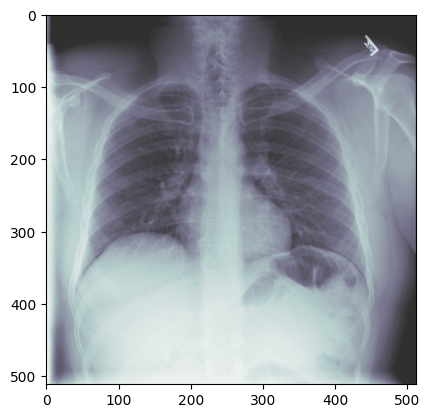

Chosen image has no ground truth mask, rerun the cell


In [45]:
# plot some random images in the `batch`
idx = random.choice(range(16))
plt.imshow(images[idx][0], cmap="bone")
plt.imshow(masks[idx][0], alpha=0.2, cmap="Reds")
plt.show()
if len(np.unique(masks[idx][0])) == 1:  # only zeros
    
    print("Chosen image has no ground truth mask, rerun the cell")

In [23]:
len(masks)

16

In [24]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return (2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError(
                "Target size ({}) must be the same as input size ({})".format(
                    target.size(), input.size()
                )
            )
        max_val = (-input).clamp(min=0)
        loss = (
            input
            - input * target
            + max_val
            + ((-max_val).exp() + (-input - max_val).exp()).log()
        )
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha * self.focal(input, target) - torch.log(
            dice_loss(input, target)
        )
        return loss.mean()

In [25]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype("uint8")
    return preds


def metric(probability, truth, threshold=0.5, reduction="none"):
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert probability.shape == truth.shape

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0).view(-1)
        pos_index = torch.nonzero(t_sum >= 1).view(-1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p * t).sum(-1) / ((p + t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice.tolist(), dice_neg.tolist(), dice_pos.tolist(), num_neg, num_pos


class Meter:
    """A meter to keep track of iou and dice scores throughout an epoch"""

    def __init__(self, phase, epoch):
        self.base_threshold = 0.5  # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    # def update(self, targets, outputs):
    #     probs = torch.sigmoid(outputs)
    #     dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
    #     self.base_dice_scores.extend(dice)
    #     self.dice_pos_scores.extend(dice_pos)
    #     self.dice_neg_scores.extend(dice_neg)
    #     preds = predict(probs, self.base_threshold)
    #     iou = compute_iou_batch(preds, targets, classes=[1])
    #     self.iou_scores.append(iou)
    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice)
        self.dice_pos_scores.extend(dice_pos)
        self.dice_neg_scores.extend(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        print(self.base_dice_scores)
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou


def epoch_log(phase, epoch, epoch_loss, meter, start):
    """logging the metrics at the end of an epoch"""
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print(
        "Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f"
        % (epoch_loss, dice, dice_neg, dice_pos, iou)
    )
    return dice, iou


def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    """computes iou for one ground truth mask and predicted mask"""
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    """computes mean iou for a batch of ground truth masks and predicted masks"""
    ious = []
    preds = np.copy(outputs)  # copy is imp
    labels = np.array(labels)  # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

## UNet with ResNet34 model

<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 400">
  <!-- Input -->
  <rect x="10" y="180" width="60" height="40" fill="#ADD8E6" stroke="black" />
  <text x="40" y="205" text-anchor="middle" font-size="12">Input</text>
  
  <!-- Encoder (ResNet34) -->
  <rect x="100" y="40" width="300" height="320" fill="#90EE90" stroke="black" />
  <text x="250" y="60" text-anchor="middle" font-size="16">Encoder (ResNet34)</text>
  
  <!-- Encoder Blocks -->
  <rect x="120" y="80" width="60" height="40" fill="#32CD32" stroke="black" />
  <text x="150" y="105" text-anchor="middle" font-size="12">Conv1</text>
  
  <rect x="120" y="140" width="60" height="40" fill="#32CD32" stroke="black" />
  <text x="150" y="165" text-anchor="middle" font-size="12">Block1</text>
  
  <rect x="120" y="200" width="60" height="40" fill="#32CD32" stroke="black" />
  <text x="150" y="225" text-anchor="middle" font-size="12">Block2</text>
  
  <rect x="120" y="260" width="60" height="40" fill="#32CD32" stroke="black" />
  <text x="150" y="285" text-anchor="middle" font-size="12">Block3</text>
  
  <rect x="120" y="320" width="60" height="40" fill="#32CD32" stroke="black" />
  <text x="150" y="345" text-anchor="middle" font-size="12">Block4</text>
  
  <!-- Bridge -->
  <rect x="420" y="180" width="60" height="40" fill="#FFA500" stroke="black" />
  <text x="450" y="205" text-anchor="middle" font-size="12">Bridge</text>
  
  <!-- Decoder -->
  <rect x="500" y="40" width="200" height="320" fill="#FFB6C1" stroke="black" />
  <text x="600" y="60" text-anchor="middle" font-size="16">Decoder</text>
  
  <!-- Decoder Blocks -->
  <rect x="520" y="80" width="60" height="40" fill="#FF69B4" stroke="black" />
  <text x="550" y="105" text-anchor="middle" font-size="12">UpBlock1</text>
  
  <rect x="520" y="140" width="60" height="40" fill="#FF69B4" stroke="black" />
  <text x="550" y="165" text-anchor="middle" font-size="12">UpBlock2</text>
  
  <rect x="520" y="200" width="60" height="40" fill="#FF69B4" stroke="black" />
  <text x="550" y="225" text-anchor="middle" font-size="12">UpBlock3</text>
  
  <rect x="520" y="260" width="60" height="40" fill="#FF69B4" stroke="black" />
  <text x="550" y="285" text-anchor="middle" font-size="12">UpBlock4</text>
  
  <rect x="520" y="320" width="60" height="40" fill="#FF69B4" stroke="black" />
  <text x="550" y="345" text-anchor="middle" font-size="12">UpBlock5</text>
  
  <!-- Output -->
  <rect x="730" y="180" width="60" height="40" fill="#ADD8E6" stroke="black" />
  <text x="760" y="205" text-anchor="middle" font-size="12">Output</text>
  
  <!-- Connections -->
  <line x1="70" y1="200" x2="100" y2="200" stroke="black" stroke-width="2" />
  <line x1="400" y1="200" x2="420" y2="200" stroke="black" stroke-width="2" />
  <line x1="480" y1="200" x2="500" y2="200" stroke="black" stroke-width="2" />
  <line x1="700" y1="200" x2="730" y2="200" stroke="black" stroke-width="2" />
  
  <!-- Skip Connections -->
  <path d="M 180 100 Q 400 100 520 100" fill="none" stroke="red" stroke-width="2" stroke-dasharray="5,5" />
  <path d="M 180 160 Q 400 160 520 160" fill="none" stroke="red" stroke-width="2" stroke-dasharray="5,5" />
  <path d="M 180 220 Q 400 220 520 220" fill="none" stroke="red" stroke-width="2" stroke-dasharray="5,5" />
  <path d="M 180 280 Q 400 280 520 280" fill="none" stroke="red" stroke-width="2" stroke-dasharray="5,5" />
</svg>

[testo da spiegare bene con schema]

1. Model Architecture: U-Net with ResNet34 Encoder

The model is created using the segmentation_models_pytorch library. 

Model Architecture: U-Net with ResNet34 Encoder

The model is created using the segmentation_models_pytorch library:

This creates a U-Net architecture with the following characteristics:
a) Encoder (Downsampling path):

Uses a pre-trained ResNet34 as the encoder.
ResNet34 consists of 5 stages, each downsampling the input:

Initial 7x7 conv, stride 2, followed by max pooling
4 residual blocks, each containing several 3x3 convolutions



b) Decoder (Upsampling path):

Consists of 5 upsampling blocks
Each block upsamples the features and concatenates with corresponding encoder features (skip connections)
Followed by convolutional layers to refine the features

c) Bridge:

Connects the encoder and decoder
Typically involves one or more convolutional layers

d) Final layer:

A 1x1 convolution to map the feature channels to the number of classes (1 in this case, for binary segmentation)


2. Loss Function:

The model uses a custom MixedLoss, combining Focal Loss and Dice Loss.

Focal Loss helps to address class imbalance by down-weighting easy examples.
Dice Loss is beneficial for segmentation tasks as it directly optimizes the overlap between prediction and ground truth.

3. Optimization:

Uses Adam optimizer, which adapts the learning rate for each parameter.
ReduceLROnPlateau scheduler reduces the learning rate when the validation loss stops improving.


4. Training Loop:
The training process is encapsulated in the Trainer class:
a) Initialization:

Sets up the model, loss function, optimizer, and data loaders.

b) Forward pass (forward method):

Moves images and masks to the device (GPU/CPU).
Passes images through the network.
Calculates the loss.

c) Training iteration (iterate method):

Iterates over batches of data.
Performs forward and backward passes.
Updates the model parameters.
Calculates and logs metrics (Dice score, IoU).

d) Overall training (start method):

Runs training for a specified number of epochs.
Alternates between training and validation phases.
Saves the best model based on validation loss

5. Data Handling
Uses a custom provider function to create data loaders for training and validation.
Applies normalization and resizing to 512x512.
Supports k-fold cross-validation (though only one fold is used in this implementation).


Metrics Calculation:


Custom functions for calculating Dice score and IoU are implemented.
These metrics are updated and logged for each batch and epoch.


Model Saving:


The best model (based on validation loss) is saved during training.
An additional save is performed at the end of training.

This implementation follows many best practices for deep learning in medical imaging:

Use of a proven architecture (U-Net) with a strong pre-trained encoder (ResNet34).
Handling of class imbalance through an appropriate loss function.
Use of relevant segmentation metrics (Dice, IoU).
Learning rate scheduling to improve convergence.
Proper separation of training and validation.

The logical flow of the training process ensures that the model is trained effectively, with regular evaluation and saving of the best-performing version. The use of PyTorch and segmentation_models_pytorch allows for efficient implementation and potential for further customization if needed.

In [26]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\alexc/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 56.2MB/s]


In [27]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [30]:
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.backends.cudnn as cudnn
import time


class Trainer(object):
    """This class takes care of training and validation of our model"""

    def __init__(self, model):
        self.model = model
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size["train"]
        self.lr = 5e-4
        self.num_epochs = 10
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        # self.device = torch.device("mps")
        self.device = torch.device("cuda:0")
        # torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode="min", patience=3, verbose=True
        )
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                data_folder=data_folder,
                df_path=train_rle_path,
                phase=phase,
                size=512,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}

    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)  # .unsqueeze(1)  # (batch_size, 1, 512, 512)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches, desc=f"Epoch {epoch} [{phase}]")
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            # print(f"Batch {itr} - targets shape: {targets.shape}, outputs shape: {outputs.shape}")
            # targets = targets.unsqueeze(1)
            meter.update(targets, outputs)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        # torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()

In [31]:
model_trainer = Trainer(model)
model_trainer.start()
model_trainer.save_model("models/segmentation_restnet34_model.pth")

Creating dataset...
Creating dataset...
Starting epoch: 0 | phase: train | ⏰: 21:24:11


Epoch 0 [train]: 100%|██████████| 939/939 [01:45<00:00,  8.87it/s, loss=0.442]


[0.006330206524580717, 0.012848934158682823, 0.0, 0.0, 0.005786191672086716, 0.02485646679997444, 0.06966037303209305, 0.0, 0.007460481487214565, 0.011022623628377914, 0.0, 0.0, 0.011124501936137676, 0.0, 0.0, 0.0, 0.03170749545097351, 0.022274382412433624, 0.0, 0.0, 0.0036880928091704845, 0.03643833100795746, 0.03690823167562485, 0.0, 0.12271604686975479, 0.0803205668926239, 0.06319069117307663, 0.0, 0.07259871810674667, 0.022653156891465187, 0.09951215237379074, 0.083025723695755, 0.012606303207576275, 0.0, 0.0, 0.0, 0.02607574313879013, 0.0, 0.0, 0.0, 0.005484755616635084, 0.005039841867983341, 0.029503192752599716, 0.0, 0.08049415796995163, 0.0, 0.0, 0.0, 0.0005788712296634912, 0.05978977307677269, 0.0, 0.0, 0.0077725304290652275, 0.06146230921149254, 0.0, 0.0, 0.04188564419746399, 0.0, 0.0, 0.0, 0.011621957644820213, 0.0, 0.0, 0.0, 0.033131193369627, 0.03488180786371231, 0.06730973720550537, 0.0, 0.002414231188595295, 0.043280068784952164, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.060414507

Epoch 0 [val]: 100%|██████████| 235/235 [00:45<00:00,  5.15it/s, loss=0.349]


[0.21960146725177765, 0.327601820230484, 0.0, 0.0, 0.3509589433670044, 0.3754423260688782, 0.4265224039554596, 1.0, 0.0, 0.0, 0.0, 0.0, 0.4280240833759308, 0.28203722834587097, 0.3257790505886078, 0.0, 0.5211509466171265, 0.0, 0.0, 0.0, 0.42052900791168213, 0.0, 0.0, 0.0, 0.2021341472864151, 0.3233787417411804, 0.0, 0.0, 0.05697575584053993, 0.33734938502311707, 0.0, 1.0, 0.02552131935954094, 0.07450628280639648, 0.6519635915756226, 0.0, 0.3512516915798187, 0.10407756268978119, 0.5081857442855835, 0.0, 0.12416388094425201, 0.0, 0.0, 0.0, 0.34521159529685974, 0.4004473388195038, 0.5860636830329895, 1.0, 0.30501410365104675, 0.31840795278549194, 0.0, 0.0, 0.48852047324180603, 0.0, 0.0, 0.0, 0.30377885699272156, 0.0, 0.0, 0.0, 0.637797474861145, 0.4621574580669403, 0.5084353089332581, 1.0, 0.0, 0.0, 0.0, 0.0, 0.3910835087299347, 0.0, 1.0, 0.0, 0.3273915648460388, 0.42184776067733765, 0.12567156553268433, 0.3098491430282593, 0.28583747148513794, 0.7172223329544067, 1.0, 0.0, 0.0, 0.0, 0.0,

Epoch 1 [train]: 100%|██████████| 939/939 [01:51<00:00,  8.39it/s, loss=0.303] 


[0.0, 0.8403338193893433, 0.409572035074234, 1.0, 0.670025646686554, 0.09001406282186508, 0.0, 0.0, 0.0986756682395935, 0.6055838465690613, 0.35817667841911316, 1.0, 0.545325517654419, 0.4331210255622864, 0.0, 0.0, 0.5820460319519043, 0.5060532689094543, 0.0, 0.0, 0.625694215297699, 0.24757280945777893, 0.41909924149513245, 1.0, 0.0, 1.0, 0.0, 0.0, 0.027824152261018753, 0.14564789831638336, 0.0, 1.0, 0.5994490385055542, 0.5298372507095337, 0.18292683362960815, 0.0, 0.5199759602546692, 0.5924506187438965, 0.0, 0.5160862803459167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.039503537118434906, 0.0, 0.0, 0.33103111386299133, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14779454469680786, 0.0, 0.3480486273765564, 0.0, 0.7778900265693665, 0.40075355768203735, 1.0, 0.0, 0.7222989797592163, 0.6876417994499207, 0.5437928438186646, 0.0, 0.4824761152267456, 0.0, 0.2655373513698578, 1.0, 0.07326578348875046, 0.33969175815582275, 0.29906541109085083, 0.0, 0.26124197244644165, 0.18854908645153046, 0.0, 0.0, 0.6717600226402

Epoch 1 [val]: 100%|██████████| 235/235 [00:37<00:00,  6.32it/s, loss=0.35] 


[0.8557056188583374, 0.1861988604068756, 0.0, 0.0, 0.1807199865579605, 1.0, 0.0, 0.0, 0.11193123459815979, 0.0, 1.0, 0.0, 0.6512410640716553, 0.0, 0.0, 0.0, 0.6560360789299011, 0.0, 0.0, 0.0, 0.37196674942970276, 0.15016761422157288, 0.4155265688896179, 0.6255446076393127, 0.7193691730499268, 0.45188283920288086, 0.5498204231262207, 0.3254079222679138, 0.760565996170044, 0.21774879097938538, 0.05993008241057396, 0.0, 0.5649108290672302, 0.5025565028190613, 0.0, 0.0, 0.33026960492134094, 0.0, 0.0, 0.0, 0.15337707102298737, 0.0, 0.0, 0.0, 0.6289159655570984, 0.6146737337112427, 1.0, 0.0, 0.11786982417106628, 0.2841852605342865, 0.0, 0.0, 0.426613986492157, 0.0, 0.0, 0.0, 0.007905138656497002, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.5784287452697754, 0.4213863015174866, 0.0, 0.0, 0.198176771402359, 0.10377515107393265, 0.0, 0.0, 0.1866239458322525, 0.0, 0.0, 1.0, 0.19919028878211975, 0.0, 0.0, 1.0, 0.7078025341033936, 0.41938847303390503, 0.0, 0.0, 0.0, 0.18184635043144226, 0.044075146317481

Epoch 2 [train]: 100%|██████████| 939/939 [01:37<00:00,  9.58it/s, loss=0.292]


[0.6489907503128052, 0.4070562422275543, 0.0, 0.0, 0.6107945442199707, 0.0, 0.0, 1.0, 0.5600131750106812, 0.0, 1.0, 0.0, 0.18722715973854065, 0.0, 1.0, 0.0, 0.34968483448028564, 0.0, 0.0, 0.0, 0.1639646291732788, 0.6004186868667603, 0.0, 0.0, 0.6195330619812012, 0.6402869820594788, 1.0, 0.0, 0.4912610650062561, 0.1554066240787506, 0.23795050382614136, 1.0, 0.0010389609960839152, 0.41802915930747986, 0.45373353362083435, 0.0, 0.1849542260169983, 0.5077605247497559, 0.0, 1.0, 0.37944984436035156, 0.0, 1.0, 0.0, 0.13183778524398804, 0.20859891176223755, 0.3475665748119354, 0.0, 0.0, 0.0, 0.3484314978122711, 1.0, 0.0, 0.8799407482147217, 1.0, 1.0, 0.12097229808568954, 0.0, 0.0, 0.0, 0.18388257920742035, 1.0, 0.0, 0.0, 0.0, 0.5286307334899902, 0.0, 0.0, 0.2470952719449997, 0.15875564515590668, 0.24668990075588226, 1.0, 0.0, 0.0, 1.0, 0.0, 0.13475492596626282, 0.356454998254776, 0.0, 1.0, 0.4191632568836212, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.43803057074546814, 0.01461632177233696, 0.05513

Epoch 2 [val]: 100%|██████████| 235/235 [00:37<00:00,  6.21it/s, loss=0.275]


[0.0, 0.1021069660782814, 0.0, 0.0, 0.14138661324977875, 0.7662397027015686, 0.34631699323654175, 0.0, 0.4464745819568634, 0.6405074596405029, 0.0, 0.0, 0.2563350796699524, 0.3731423020362854, 0.18122635781764984, 1.0, 0.7230862379074097, 0.0, 1.0, 0.0, 0.22657427191734314, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.2945406138896942, 0.49500772356987, 1.0, 1.0, 0.6279760003089905, 0.7357414364814758, 0.0, 0.0, 0.0, 0.5015360116958618, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.12130718678236008, 1.0, 1.0, 0.0, 0.1767195761203766, 0.7674469351768494, 0.0, 0.0, 0.6702744364738464, 0.7302204966545105, 0.0, 1.0, 0.10922787338495255, 0.595129668712616, 0.7041481137275696, 0.22099915146827698, 0.0, 0.0, 0.0, 0.0, 0.4532727897167206, 1.0, 0.0, 1.0, 0.23379555344581604, 0.32665014266967773, 0.06446586549282074, 0.0, 0.1830153614282608, 0.11499118059873581, 0.5397640466690063, 1.0, 0.5809653997421265, 0.7812765836715698, 0.0, 1.0, 0.031971581280231476, 0.5873982310295105, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.4709813

Epoch 3 [train]: 100%|██████████| 939/939 [01:37<00:00,  9.59it/s, loss=0.252]


[0.19415158033370972, 0.39201709628105164, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.40843555331230164, 0.08822339028120041, 0.6106808185577393, 1.0, 0.354320764541626, 0.0, 0.5169447064399719, 0.5159215331077576, 0.15707333385944366, 0.11048367619514465, 0.0, 0.0, 0.49704816937446594, 0.0, 0.0, 0.0, 0.0839160829782486, 0.5982424020767212, 0.6987990736961365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4349726736545563, 0.475191205739975, 0.0, 1.0, 0.7769855856895447, 0.7598713636398315, 1.0, 1.0, 0.4872705936431885, 0.34206873178482056, 0.25602659583091736, 1.0, 0.7338418364524841, 0.0, 0.7561280727386475, 0.0, 0.8518688082695007, 0.0, 0.0, 0.0, 0.7387978434562683, 0.0, 0.0, 1.0, 0.0, 0.28192874789237976, 1.0, 1.0, 0.4453141987323761, 0.5864732265472412, 0.16766467690467834, 1.0, 0.3341067433357239, 0.0, 0.0, 0.0, 0.359020859003067, 0.5546402335166931, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.2443235069513321, 0.0, 1.0, 0.0, 0.7421602606773376, 0.7650085687637329, 1.0, 1.0, 0.0, 0.46942609548568726, 1.0, 1.0, 0.09742198

Epoch 3 [val]: 100%|██████████| 235/235 [00:37<00:00,  6.26it/s, loss=0.275]


[0.13290229439735413, 0.1302250772714615, 0.0, 0.0, 0.736123263835907, 0.0, 0.0, 0.0, 0.20034393668174744, 0.0, 0.0, 0.0, 0.23521564900875092, 0.8279362916946411, 0.0, 0.0, 0.3986724019050598, 0.0, 0.0, 0.0, 0.17336152493953705, 0.42703646421432495, 0.6994892358779907, 0.0, 0.7073986530303955, 0.6772857308387756, 0.0, 1.0, 0.251939982175827, 0.4943408668041229, 0.14147046208381653, 0.0, 0.28382837772369385, 0.3368200957775116, 0.0, 0.0, 0.2980427145957947, 0.34776565432548523, 0.0, 0.0, 0.4817556142807007, 0.5538958311080933, 0.0, 0.0, 0.230105459690094, 0.33445656299591064, 0.0, 0.0, 0.6126609444618225, 0.0, 0.0, 0.0, 0.5933484435081482, 0.0476190485060215, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.27541372179985046, 0.23215197026729584, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5030696988105774, 0.4407806098461151, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025974025949835777, 0.5849695205688477, 0.0, 0.0, 0.4099397361278534, 0.0, 0.0, 0.0, 0.11307305842638016, 0.30400347709

Epoch 4 [train]: 100%|██████████| 939/939 [01:36<00:00,  9.74it/s, loss=0.245]


[0.4271540343761444, 0.0, 0.0, 0.0, 0.43830227851867676, 0.5459521412849426, 0.0, 0.0, 0.2624197006225586, 0.5465838313102722, 0.09237875044345856, 0.0, 0.46690481901168823, 0.10479103028774261, 0.0, 0.0, 0.592739462852478, 0.0, 0.0, 0.0, 0.43393251299858093, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4184361696243286, 0.0, 0.0, 0.0, 0.42889365553855896, 0.6620486974716187, 0.09787928313016891, 1.0, 0.7682462334632874, 0.5133447051048279, 0.7141404151916504, 1.0, 0.0824742242693901, 0.5406448245048523, 0.5991910696029663, 0.0, 0.4522821605205536, 0.5092757344245911, 0.0, 0.0, 0.4470292329788208, 0.0, 0.0, 0.0, 0.42421525716781616, 0.0, 0.0, 0.0, 0.2941693663597107, 0.5032051205635071, 0.0, 0.0, 0.20411081612110138, 0.0, 0.0, 0.0, 0.15789473056793213, 0.3417603075504303, 0.0, 0.0, 0.3074779510498047, 0.0, 0.0, 1.0, 0.6796949505805969, 1.0, 0.0, 0.0, 0.7279506325721741, 0.35303983092308044, 0.0, 1.0, 0.568965494632721, 1.0, 0.0, 0.0, 0.1468043476343155, 0.5451481342315674, 0.0, 0.0, 0.53071612

Epoch 4 [val]: 100%|██████████| 235/235 [00:37<00:00,  6.24it/s, loss=0.303] 


[0.7545899152755737, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.7566484212875366, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.6990163326263428, 0.5656565427780151, 1.0, 1.0, 0.03882099315524101, 0.0, 1.0, 1.0, 0.7726780772209167, 1.0, 1.0, 0.0, 0.0, 0.0, 0.6278999447822571, 0.0, 0.6629146337509155, 0.575035035610199, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.30983301997184753, 0.0, 1.0, 0.31669536232948303, 0.6605197191238403, 1.0, 1.0, 0.0, 0.6078028678894043, 0.784401535987854, 1.0, 0.07526881992816925, 0.46035560965538025, 1.0, 0.0, 0.11754537373781204, 0.7872447371482849, 1.0, 1.0, 0.4603748619556427, 0.31147539615631104, 0.0, 0.0, 0.14941860735416412, 0.019272061064839363, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.10463268309831619, 1.0, 1.0, 0.2767665982246399, 1.0, 0.0, 0.0, 0.28733789920806885, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.2913811206817627, 0.012762078084051609, 0.21879194676876068, 0.5245499014854431, 0.0, 1.0, 0.0, 1.0, 0.4327555298805237, 0.4716981053352356, 0.564459919

Epoch 5 [train]: 100%|██████████| 939/939 [01:36<00:00,  9.76it/s, loss=0.257] 


[0.8601439595222473, 0.0, 1.0, 1.0, 0.2607702314853668, 0.5785428881645203, 0.5212827920913696, 1.0, 0.7309927344322205, 0.0, 1.0, 1.0, 0.0013036595191806555, 0.0, 0.8161909580230713, 0.0, 0.20206022262573242, 0.0, 0.0, 0.0, 0.09112709760665894, 0.616839587688446, 0.0, 1.0, 0.5417658090591431, 0.1799650490283966, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.43601059913635254, 0.48308223485946655, 0.0, 1.0, 0.3689320385456085, 1.0, 0.0, 0.0, 0.0, 0.5918653607368469, 1.0, 1.0, 0.3054054081439972, 0.7769909501075745, 0.0, 1.0, 0.8084880113601685, 0.0, 1.0, 1.0, 0.030587604269385338, 0.0, 0.21889764070510864, 0.39834240078926086, 0.4008483588695526, 0.28349238634109497, 0.0, 1.0, 0.19488535821437836, 0.0, 0.0, 1.0, 0.4219636023044586, 0.49273958802223206, 0.0, 1.0, 0.8475473523139954, 0.05238649621605873, 0.0, 0.0, 0.0, 0.7773376703262329, 0.0, 1.0, 0.5221245884895325, 0.25651633739471436, 1.0, 1.0, 0.0, 0.019747668877243996, 0.41201716661453247, 1.0, 0.20789942145347595, 0.819756269454956, 0.313449233

Epoch 5 [val]: 100%|██████████| 235/235 [00:36<00:00,  6.39it/s, loss=0.231]


[0.1906045377254486, 0.0, 1.0, 0.0, 0.6779559850692749, 1.0, 0.0, 1.0, 0.2284843921661377, 0.6208680868148804, 0.0, 0.0, 0.0, 0.7655969858169556, 0.7009631991386414, 0.0, 0.0, 0.5389947891235352, 0.2634836435317993, 0.0, 0.22913992404937744, 0.2545846700668335, 0.35044026374816895, 0.0, 0.37745097279548645, 0.821857213973999, 0.0939597338438034, 0.0, 0.27260735630989075, 0.8700237274169922, 0.0, 1.0, 0.48234090209007263, 0.669080376625061, 1.0, 0.0, 0.0, 0.4769287705421448, 1.0, 1.0, 0.2442748099565506, 0.7832827568054199, 0.0, 0.0, 0.5293586254119873, 0.5896822810173035, 0.0, 0.061349693685770035, 0.17198248207569122, 0.2997285723686218, 0.0, 0.0, 0.8050915002822876, 0.0, 0.0, 1.0, 0.0887918472290039, 0.0007154355407692492, 0.0, 1.0, 0.2676093280315399, 0.0, 1.0, 0.0, 0.20338982343673706, 0.8194976449012756, 1.0, 0.0, 0.0, 0.6455974578857422, 1.0, 1.0, 0.6338068842887878, 0.5909961462020874, 0.0, 1.0, 0.67954021692276, 0.5179578065872192, 0.0, 1.0, 0.8483914136886597, 0.60211461782455

Epoch 6 [train]: 100%|██████████| 939/939 [01:37<00:00,  9.59it/s, loss=0.247]


[0.3778470456600189, 0.0, 0.0, 0.0, 0.5770246386528015, 0.46921518445014954, 0.6126237511634827, 0.2700587213039398, 0.3212290406227112, 0.0, 0.3430774509906769, 0.0, 0.7442159652709961, 0.0, 0.0, 0.0, 0.7219069004058838, 0.0, 0.0, 0.0, 0.48601973056793213, 0.0, 0.5072263479232788, 0.0, 0.4717821776866913, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.32750242948532104, 0.0, 0.0, 0.0, 0.8012486696243286, 0.2227238565683365, 0.3992805778980255, 1.0, 0.5456953644752502, 0.48603081703186035, 0.5350532531738281, 1.0, 0.0, 0.6002562642097473, 0.6562731862068176, 0.24892175197601318, 0.24066390097141266, 0.1372629851102829, 0.44810789823532104, 0.0, 1.0, 0.0, 0.0, 0.0, 0.7716322541236877, 0.37539321184158325, 0.0, 1.0, 0.8162136673927307, 0.4205838739871979, 0.0, 1.0, 0.7665073871612549, 0.0, 0.025641025975346565, 1.0, 0.0, 0.38525834679603577, 0.7953674793243408, 1.0, 0.3553912043571472, 0.3918851912021637, 0.0, 0.0, 0.039487726986408234, 0.6152144074440002, 0.0, 1.0, 0.0, 0.0, 1

Epoch 6 [val]: 100%|██████████| 235/235 [00:36<00:00,  6.38it/s, loss=0.268]


[0.4078250825405121, 0.0, 0.0, 1.0, 0.11407199501991272, 0.0, 0.0, 0.0, 0.6954928636550903, 0.6994042992591858, 0.0, 0.0, 0.5246203541755676, 0.15598507225513458, 0.6003842353820801, 1.0, 0.7886238098144531, 0.0, 1.0, 0.0, 0.5060442090034485, 0.0, 0.0, 1.0, 0.18934911489486694, 0.26965323090553284, 0.0, 0.0, 0.22457490861415863, 0.0, 0.0, 0.0, 0.33892616629600525, 0.0, 0.0, 0.0, 0.23107123374938965, 0.19200000166893005, 1.0, 0.0, 0.2423887550830841, 0.0, 1.0, 1.0, 0.6969972848892212, 0.2924037575721741, 0.6360946893692017, 0.0, 0.41961851716041565, 0.6805479526519775, 0.0, 0.0, 0.7573602795600891, 0.33639463782310486, 0.0, 0.0, 0.19711539149284363, 0.5864498615264893, 0.12080536782741547, 0.0, 0.5288293361663818, 1.0, 1.0, 0.0, 0.36953872442245483, 0.26097559928894043, 1.0, 0.0, 0.5655032992362976, 0.3796711564064026, 0.21376608312129974, 0.0, 0.5608202815055847, 0.0, 0.0, 0.0, 0.7901461720466614, 0.6320419311523438, 0.6026111841201782, 0.7255216836929321, 0.8059155941009521, 0.0868710

Epoch 7 [train]: 100%|██████████| 939/939 [01:36<00:00,  9.73it/s, loss=0.242]


[0.0, 0.7528617978096008, 0.0, 0.0, 0.5860496759414673, 0.0, 0.0, 0.0, 0.2678571343421936, 0.6024744510650635, 0.0, 0.0, 0.7972003817558289, 0.0, 0.4177897572517395, 0.0, 0.5425223112106323, 0.22532403469085693, 0.0, 0.0, 0.5166047215461731, 0.0, 0.0, 0.0, 0.3184880316257477, 0.0, 0.0, 1.0, 0.3336661159992218, 0.07230830192565918, 0.0, 0.0, 0.7927723526954651, 0.040453433990478516, 0.0, 0.0, 0.21950224041938782, 0.0, 0.0, 0.0, 0.8035401105880737, 0.6337448358535767, 0.0, 1.0, 0.7399854063987732, 0.500618040561676, 0.0, 1.0, 0.0, 0.7417218685150146, 0.0, 0.0, 0.25284090638160706, 0.5786707997322083, 1.0, 0.0, 0.29143258929252625, 0.0, 0.0, 0.0, 0.6783742904663086, 0.5375062227249146, 0.0, 0.0, 0.4161156117916107, 0.5821069478988647, 0.0, 1.0, 0.2186688929796219, 0.15941569209098816, 0.0, 0.0, 0.0, 0.19577814638614655, 0.0, 0.0, 0.0, 0.6955668330192566, 0.0, 1.0, 0.32348111271858215, 0.07922966778278351, 0.0, 0.0, 0.5340387225151062, 0.0, 1.0, 1.0, 0.40148183703422546, 0.7476570010185242

Epoch 7 [val]: 100%|██████████| 235/235 [00:37<00:00,  6.33it/s, loss=0.272]


[0.12402806431055069, 0.6270333528518677, 0.0, 1.0, 0.3030114769935608, 0.6140410900115967, 0.8160063028335571, 0.2374727725982666, 0.0, 0.0, 0.0, 1.0, 0.3369499742984772, 0.0, 0.0, 1.0, 0.8259052634239197, 0.7469040155410767, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.9176033735275269, 1.0, 1.0, 0.0, 0.3604240417480469, 0.8456260561943054, 1.0, 0.0, 0.21346242725849152, 1.0, 0.0, 0.797676682472229, 0.0, 0.7723093628883362, 1.0, 0.09197324514389038, 0.0, 1.0, 1.0, 0.6365591287612915, 1.0, 1.0, 1.0, 0.0, 0.019434629008173943, 0.0011650073574855924, 1.0, 0.27022820711135864, 0.5665419697761536, 1.0, 1.0, 0.5632458329200745, 0.7402269840240479, 1.0, 1.0, 0.6338629722595215, 0.43398693203926086, 0.0, 1.0, 0.029874788597226143, 1.0, 1.0, 1.0, 0.5602558255195618, 0.640681803226471, 0.6969898343086243, 0.0, 1.0, 0.0, 1.0, 1.0, 0.6888683438301086, 1.0, 1.0, 0.0, 0.4698528051376343, 0.7257799506187439, 0.5978947281837463, 1.0, 0.008537886664271355, 0.478608101606369, 1.0, 0.0, 0.0

Epoch 8 [train]: 100%|██████████| 939/939 [01:36<00:00,  9.75it/s, loss=0.222] 


[0.6927480697631836, 1.0, 0.0, 1.0, 0.8843324184417725, 0.5592840909957886, 0.5869166254997253, 1.0, 0.7073466777801514, 0.7449392676353455, 0.0, 1.0, 0.7563333511352539, 1.0, 0.0, 1.0, 0.5107843279838562, 0.36310839653015137, 1.0, 1.0, 0.6745743155479431, 1.0, 1.0, 1.0, 0.5017972588539124, 0.6327933073043823, 0.0, 0.0, 0.07438556849956512, 0.0, 1.0, 0.0, 0.6189801692962646, 0.5574442148208618, 0.0, 1.0, 0.0, 0.6705202460289001, 0.6492621898651123, 1.0, 0.28811022639274597, 0.0, 0.7048839330673218, 1.0, 0.26925092935562134, 0.6142042279243469, 0.0, 1.0, 0.488571435213089, 1.0, 0.0, 1.0, 0.5013174414634705, 0.0, 0.0, 1.0, 0.0, 0.7669562101364136, 1.0, 1.0, 0.6176883578300476, 0.47934845089912415, 0.7222635746002197, 1.0, 0.18957771360874176, 0.6216842532157898, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.8624734878540039, 0.0019286402966827154, 0.28145429491996765, 1.0, 0.26026248931884766, 1.0, 0.0, 0.0, 0.7791164517402649, 0.10744932293891907, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.8112384080886841, 1.0

Epoch 8 [val]: 100%|██████████| 235/235 [00:37<00:00,  6.33it/s, loss=0.233]


[0.1393258422613144, 1.0, 1.0, 1.0, 0.840718686580658, 0.7433143854141235, 0.28558850288391113, 0.0, 0.1672581434249878, 1.0, 0.0, 1.0, 0.0, 0.28626197576522827, 1.0, 0.0, 0.5856106877326965, 0.014254271052777767, 1.0, 0.0, 0.03913894295692444, 0.0, 0.0, 0.0, 0.5310376286506653, 0.5982255935668945, 1.0, 0.0, 0.6130380034446716, 0.6675369143486023, 1.0, 1.0, 0.1538461595773697, 1.0, 0.0, 1.0, 0.07153729349374771, 0.7500472664833069, 0.10000000149011612, 0.0, 0.0, 0.6494259238243103, 0.0, 0.0, 0.5741488933563232, 1.0, 1.0, 1.0, 0.0, 0.17822106182575226, 0.827203094959259, 0.5832716226577759, 0.8894171118736267, 0.0, 0.0, 0.0, 0.784171998500824, 1.0, 0.0, 0.0, 0.6288161277770996, 0.1930270940065384, 0.0, 0.0, 0.46654772758483887, 1.0, 1.0, 0.0, 0.7192474603652954, 0.2947368323802948, 0.0, 1.0, 0.06646525859832764, 0.38498789072036743, 0.3015913665294647, 0.0, 0.8595946431159973, 0.5890772342681885, 0.0, 1.0, 0.5024330615997314, 0.4524298310279846, 0.0, 0.0, 0.5020576119422913, 0.002375120

Epoch 9 [train]: 100%|██████████| 939/939 [01:41<00:00,  9.29it/s, loss=0.222]


[0.6301894187927246, 0.2807376980781555, 1.0, 0.0, 0.5763747692108154, 0.3947541117668152, 0.01779215596616268, 0.0, 0.6414066553115845, 0.68410724401474, 0.6256410479545593, 1.0, 0.0, 0.0, 0.0, 1.0, 0.912686288356781, 1.0, 0.0, 0.0, 0.36679673194885254, 0.023541048169136047, 0.0, 0.0, 0.5648579597473145, 0.7285911440849304, 0.5643793344497681, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5778781175613403, 1.0, 1.0, 1.0, 0.7105706334114075, 0.48897290229797363, 0.43140965700149536, 1.0, 0.5905044674873352, 0.3395427465438843, 0.0, 1.0, 0.29511985182762146, 0.0, 0.0, 0.0, 0.6496732831001282, 0.5364387631416321, 1.0, 1.0, 0.2626896798610687, 0.5898017287254333, 0.0, 0.0, 0.25592416524887085, 0.7749093174934387, 0.8311561942100525, 0.5940959453582764, 0.559816837310791, 0.5459389090538025, 0.0, 1.0, 0.3237971365451813, 0.20424340665340424, 0.5601115226745605, 1.0, 0.4812335669994354, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.8979218602180481, 0.7949526906013489, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,

Epoch 9 [val]: 100%|██████████| 235/235 [00:37<00:00,  6.27it/s, loss=0.227]


[0.7561987638473511, 1.0, 1.0, 0.0, 0.7085930109024048, 0.0, 0.0, 1.0, 0.0026350461412221193, 0.2512509822845459, 1.0, 0.0, 0.5141258835792542, 0.7693665027618408, 0.8160569071769714, 1.0, 0.3791915774345398, 0.669658899307251, 0.6445881724357605, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.2712153494358063, 1.0, 1.0, 0.23382045328617096, 0.6937189698219299, 1.0, 1.0, 0.5356622934341431, 1.0, 1.0, 1.0, 0.28950631618499756, 0.39777541160583496, 1.0, 1.0, 0.5364341139793396, 1.0, 1.0, 1.0, 0.7778415679931641, 0.48275861144065857, 1.0, 0.0, 0.2213691622018814, 0.7273945212364197, 0.0, 1.0, 0.5925925970077515, 0.3352990746498108, 0.20992016792297363, 1.0, 0.7499350905418396, 0.18164436519145966, 0.0, 0.0, 0.0, 0.35173502564430237, 1.0, 1.0, 0.3548426628112793, 0.6484091877937317, 0.0, 1.0, 0.1890452653169632, 0.0, 0.025974025949835777, 1.0, 0.5741208791732788, 0.6976436972618103, 1.0, 1.0, 0.6016949415206909, 0.8122020959854126, 0.5026693940162659, 0.0, 0.5434116721153259, 0.021288210526108742, 1.0, 1

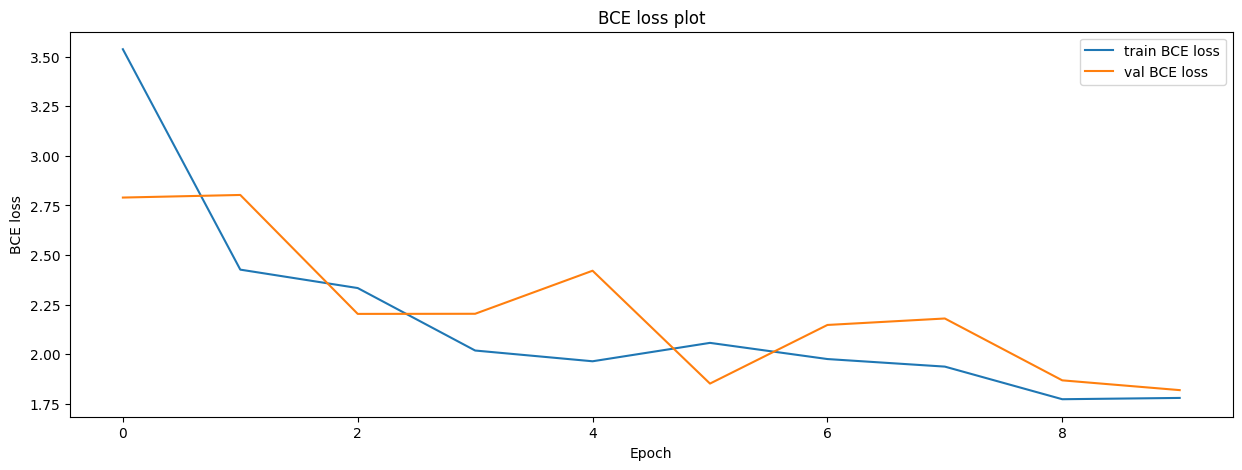

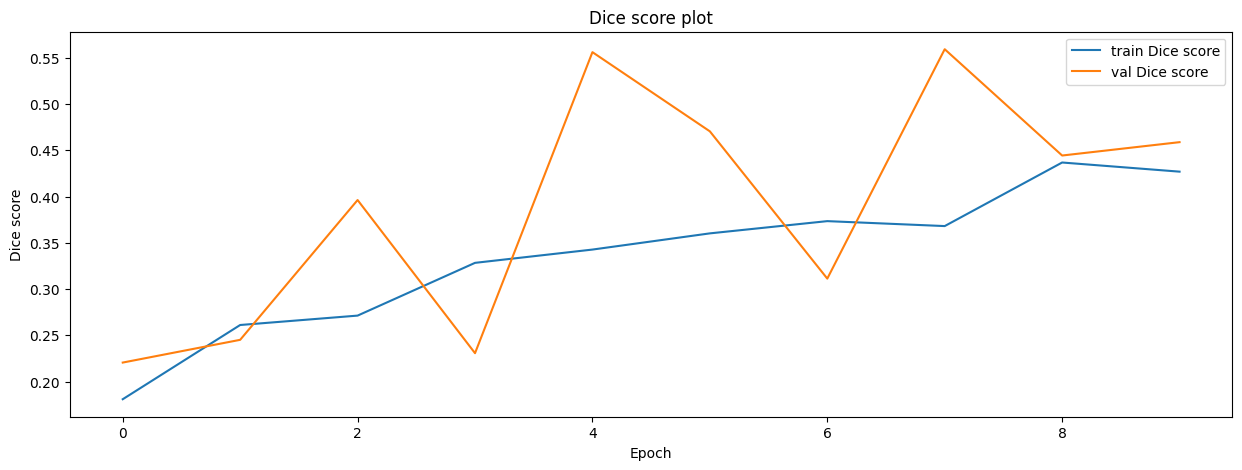

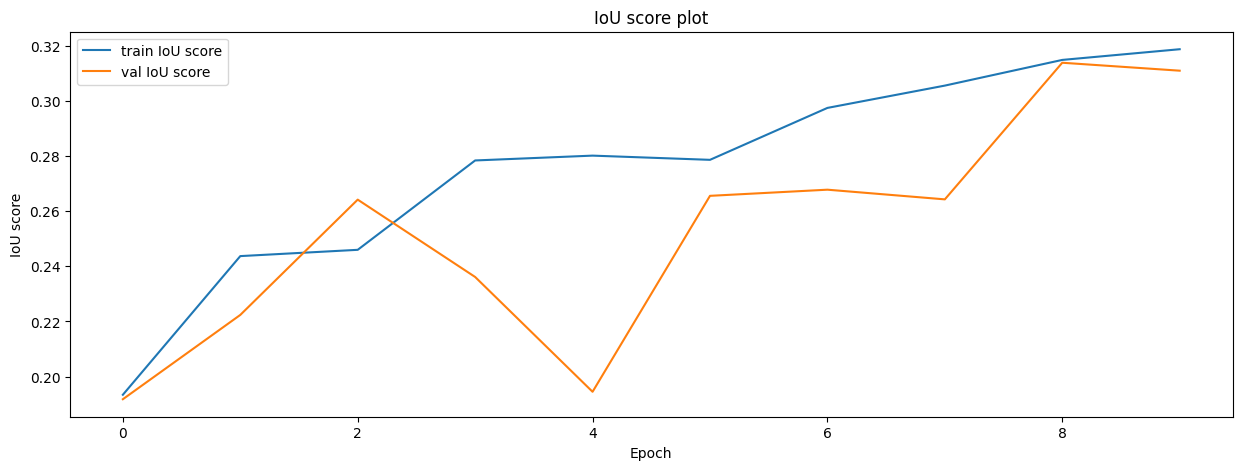

In [33]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores  # overall dice
iou_scores = model_trainer.iou_scores


def plot(scores, name):
    plt.figure(figsize=(15, 5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f"train {name}")
    plt.plot(range(len(scores["train"])), scores["val"], label=f"val {name}")
    plt.title(f"{name} plot")
    plt.xlabel("Epoch")
    plt.ylabel(f"{name}")
    plt.legend()
    plt.show()


plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

In [1]:
plot(iou_scores, "IoU score")

NameError: name 'plot' is not defined

# Appendix

## Bibliography on the CNN models used

**CheXNet-inspired** (DenseNet121):

    Rajpurkar, P., et al. (2017). "CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning."
    https://arxiv.org/pdf/1711.05225.pdf

    Huang, G., et al. (2017). "Densely Connected Convolutional Networks."
    https://arxiv.org/pdf/1608.06993.pdf


**X-RayGAN-inspired**:

    Salehinejad, H., et al. (2018). "Generalization of Deep Neural Networks for Chest Pathology Classification in X-Rays Using Generative Adversarial Networks."
    https://arxiv.org/pdf/1712.01636.pdf

    Goodfellow, I., et al. (2014). "Generative Adversarial Nets."
    https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf


**CheXpert-inspired** (ResNet18):

    Irvin, J., et al. (2019). "CheXpert: A Large Chest Radiograph Dataset with Uncertainty Labels and Expert Comparison."
    https://arxiv.org/pdf/1901.07031.pdf

    He, K., et al. (2016). "Deep Residual Learning for Image Recognition."
    https://arxiv.org/pdf/1512.03385.pdf


## How to set up nVidia GPU (notes on Cuda and cuDNN)

**GPU model**: nVidia RTX 4070Ti

First, create a virtual environment with Python 3.12.

1) Scaricati e installa CUDA 12.1 (NO ALTRE VERSIONI per come useremo PyTorch) da qui https://developer.nvidia.com/cuda-12-1-0-download-archive
2) scaricati il pacchetto cuDDN 9.2.1 da qui https://developer.nvidia.com/cudnn-downloads?target_os=Windows&target_arch=x86_64&target_version=Agnostic&cuda_version=12
3) unzippa il cuDNN e inserisci i contenuti delle cartelle *lib*, *bin* e *include* nelle rispettive cartelle lib, bin e include del percorso "C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1"
4) le variabili dovrebbero essere già tutte su PATH, in caso non lo fossero segui questa guida: https://medium.com/thesecmaster/step-by-step-guide-to-setup-pytorch-for-your-gpu-on-windows-10-11-524d58cf2744



Test for checking correct operational GPU

In [14]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")


GPU: NVIDIA GeForce RTX 4050 Laptop GPU is available.


In [1]:
import torch
import time

def test_cuda():
    print(f"CUDA is available: {torch.cuda.is_available()}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    if torch.cuda.is_available():
        print(f"Current CUDA device: {torch.cuda.current_device()}")
        print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

    # Larger matrix size
    sizes = [1000, 5000, 10000]

    for size in sizes:
        print(f"\nTesting with matrix size: {size}x{size}")
        x = torch.randn(size, size)

        # Warm-up GPU
        if torch.cuda.is_available():
            warm_up = torch.randn(1000, 1000).cuda()
            warm_up_result = warm_up.matmul(warm_up)
            del warm_up, warm_up_result
            torch.cuda.empty_cache()

        # Time CPU operation
        start_time = time.time()
        cpu_result = x.matmul(x)
        cpu_time = time.time() - start_time
        print(f"CPU time: {cpu_time:.4f} seconds")

        # Time GPU operation
        if torch.cuda.is_available():
            x_gpu = x.cuda()
            torch.cuda.synchronize()
            start_time = time.time()
            gpu_result = x_gpu.matmul(x_gpu)
            torch.cuda.synchronize()
            gpu_time = time.time() - start_time
            print(f"GPU time: {gpu_time:.4f} seconds")
            del x_gpu, gpu_result
            torch.cuda.empty_cache()
        else:
            print("CUDA is not available, skipping GPU test.")

        del x, cpu_result

if __name__ == "__main__":
    test_cuda()

CUDA is available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 4050 Laptop GPU

Testing with matrix size: 1000x1000
CPU time: 0.0274 seconds
GPU time: 0.0010 seconds

Testing with matrix size: 5000x5000
CPU time: 0.4457 seconds
GPU time: 0.0613 seconds

Testing with matrix size: 10000x10000
CPU time: 3.2506 seconds
GPU time: 0.5829 seconds


In [1]:
#%pip install albumentations

  Using cached albumentations-1.4.11-py3-none-any.whl.metadata (39 kB)
  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Using cached albucore-0.0.12-py3-none-any.whl.metadata (3.1 kB)
  Using cached eval_type_backport-0.2.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
Using cached albumentations-1.4.11-py3-none-any.whl (165 kB)
Using cached albucore-0.0.12-py3-none-any.whl (8.4 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Using cached pydantic-2.8.2-py3-none-any.whl (423 kB)
Using cached eval_type_backport-0.2.0-py3-none-any.whl (5.9 kB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Note: you may need to restart the kernel to use updated packages.
